# 📊 Caderno de Análises — EDA Completa (Planos de Saúde)
**Objetivo:** executar uma EDA padronizada com foco em custos e risco.

**Inclui:** heatmap de ausentes corrigido, matrizes de correlação (geral, risk_score, is_high_risk), pizzas para binárias, gráficos originais e tabelas multivariáveis.


## 0) Ambiente e requisitos
- Python 3.10+
- `pandas`, `numpy`, `seaborn`, `matplotlib`

Se necessário:
```bash
pip install pandas numpy seaborn matplotlib
```

In [1]:

# === 1) Configurações gerais ===
from pathlib import Path

CSV_PATH = Path("/Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/data/full_warehouse_merged.csv")
# CSV_PATH = Path("/mnt/data/full_warehouse_merged.csv")

TARGET_CANDIDATES = ["annual_medical_cost", "annual_premium", "monthly_premium"]
MAX_PAIRPLOT_VARS = 8
MAX_SCATTERS = 10
MAX_BOXPLOTS = 12
LOW_CARDINALITY_MAX = 30
SAMPLE_FOR_SCATTER = 8000
SAVE_FIGS = False
FIG_DPI = 110

TOPN_RISK = 15
MAX_PIES_BINARIES = 999
MISSING_TOKENS_STR = {"no_data", "nd", "na", "n/a", "sem_dado", "sem_dados", ""}
MISSING_TOKENS_NUM = {-1, -1.0}


In [2]:
# === 1.1) Limpeza inicial: substituir -1 por NaN e remover outliers ===
import pandas as pd
import numpy as np
from IPython.display import display

print(f"Lendo CSV de entrada: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)
print("Dimensões originais:", df.shape)

# =====================================================
# 1) Substituir DEFINITIVAMENTE -1 → NaN
# =====================================================
MISSING_TOKENS_STR = {"no_data", "nd", "na", "n/a", "sem_dado", "sem_dados", ""}
MISSING_TOKENS_NUM = {-1, -1.0}

df = df.replace(MISSING_TOKENS_NUM.union(MISSING_TOKENS_STR), np.nan)

print("✔ -1, -1.0 e tokens de missing foram convertidos em NaN.")

# =====================================================
# 2) Detectar e marcar outliers em TODAS as colunas numéricas
#    (substituindo apenas o valor outlier por NaN, sem apagar linhas)
# =====================================================
num_cols = df.select_dtypes(include=["number"]).columns.tolist()

total_cells_outliers = 0
outlier_mask_global = pd.Series(False, index=df.index)  # só para estatística
outlier_report = []

for col in num_cols:
    series = df[col].dropna()
    if series.empty:
        continue
    
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    if iqr == 0 or np.isnan(iqr):
        continue
    
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    # máscara de outlier na coluna
    col_mask = (df[col] < lower) | (df[col] > upper)
    qtd = int(col_mask.sum())

    if qtd > 0:
        outlier_report.append({
            "coluna": col,
            "lim_inf": lower,
            "lim_sup": upper,
            "qtd_outliers": qtd,
        })
        total_cells_outliers += qtd
        # acumula linhas que tiveram pelo menos 1 outlier (para estatística)
        outlier_mask_global |= col_mask

        # >>> AQUI A MÁGICA: zera só o dado outlier (vira NaN), não a linha inteira
        df.loc[col_mask, col] = np.nan

total_rows_with_outlier = int(outlier_mask_global.sum())
print(f"\nTotal de células marcadas como outlier (trocadas por NaN): {total_cells_outliers}")
print(f"Total de linhas que tinham pelo menos 1 outlier em alguma coluna numérica: {total_rows_with_outlier}")

if outlier_report:
    display(pd.DataFrame(outlier_report).sort_values("qtd_outliers", ascending=False))
else:
    print("Nenhum outlier encontrado pelas regras de IQR.")

# (repara que NÃO tem mais drop de linha aqui!)
# NADA de: df = df.loc[~outlier_mask_global].copy()

# =====================================================
# 3) SALVAR DE VOLTA NO MESMO CSV (como você pediu)
# =====================================================
df.to_csv(CSV_PATH, index=False)
print(f"\n✔ CSV atualizado e limpo salvo em: {CSV_PATH}")

display(df.head())


import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

sns.set(style="whitegrid", palette="viridis", font_scale=1.05)


Lendo CSV de entrada: /Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/data/full_warehouse_merged.csv
Dimensões originais: (64800, 59)
✔ -1, -1.0 e tokens de missing foram convertidos em NaN.

Total de células marcadas como outlier (trocadas por NaN): 54419
Total de linhas que tinham pelo menos 1 outlier em alguma coluna numérica: 27683


coluna     lim_inf      lim_sup  qtd_outliers
5     total_claims_paid  -2651.6775    4419.4625          4539
1        annual_premium   -121.0950    1132.6650          4428
2       monthly_premium    -10.0900      94.3900          4427
4      avg_claim_amount  -1281.9375    2136.5625          4330
10                hba1c      4.2600       6.6600          4320
16           dependents     -1.5000       2.5000          4132
14               income -40600.0000  124200.0000          3639
12                copay     -5.0000      35.0000          3350
3          claims_count     -3.0000       5.0000          3335
11           deductible  -1750.0000    4250.0000          3233
15       household_size      0.5000       4.5000          2640
6         chronic_count     -1.5000       2.5000          1793
0   annual_medical_cost  -2064.6650    6435.4550          1490
23       proc_lab_count     -1.5000       2.5000          1373
22   proc_consult_count     -1.5000       2.5000          1372
18     visits_last_year     -2.0000       6.0000          1349
20   proc_imaging_count     -1.5000       2.5000          1313
21    proc_physio_count     -1.5000       2.5000          1297
8          diastolic_bp     49.0000      97.0000           427
17                  bmi     13.4000      40.6000           403
9                   ldl     38.0500     201.6500           394
7           systolic_bp     75.5000     159.5000           373
19     medication_count     -3.0000       5.0000           296
13     provider_quality      1.9550       5.1950           166


✔ CSV atualizado e limpo salvo em: /Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/data/full_warehouse_merged.csv


person_id  annual_medical_cost  annual_premium  monthly_premium  \
0          1               839.85          290.63            24.22   
1          2               709.72          278.13            23.18   
2          3              1589.27          372.57            31.05   
3          4              3246.81          677.54            56.46   
4          6              1462.55          350.40            29.20   

   claims_count  avg_claim_amount  total_claims_paid  hypertension  diabetes  \
0           1.0            410.76             410.76             0         0   
1           1.0            269.00             269.00             0         0   
2           4.0            270.00            1080.00             1         0   
3           0.0              0.00               0.00             0         0   
4           3.0            219.58             658.74             1         0   

   asthma  ...  proc_imaging_count  proc_surgery_count  proc_physio_count  \
0       0  ...                 2.0                   0                1.0   
1       0  ...                 0.0                   0                0.0   
2       0  ...                 0.0                   0                1.0   
3       0  ...                 0.0                   0                0.0   
4       0  ...                 0.0                   0                1.0   

   proc_consult_count  proc_lab_count  had_major_procedure        cost_id  \
0                 0.0             0.0                    0  cost_id_31150   
1                 0.0             0.0                    0  cost_id_61371   
2                 0.0             0.0                    0  cost_id_63662   
3                 1.0             2.0                    0  cost_id_17436   
4                 0.0             0.0                    0  cost_id_59155   

         policy_id        record_id        visit_id  
0  policy_id_00033  record_id_36092  visit_id_40611  
1  policy_id_00119  record_id_45363  visit_id_48818  
2  policy_id_00176  record_id_64734  visit_id_01246  
3  policy_id_00112  record_id_43770  visit_id_47786  
4  policy_id_00017  record_id_61337  visit_id_35905  

[5 rows x 59 columns]

In [3]:

# === 3) Helpers gerais ===
def tight_title(title, width=80):
    import textwrap as _tw
    return "\n".join(_tw.wrap(title, width=width))

def ensure_figdir():
    out = Path("figs"); out.mkdir(exist_ok=True); return out

def savefig_maybe(name):
    if SAVE_FIGS:
        outdir = ensure_figdir()
        plt.savefig(outdir / f"{name}.png", dpi=FIG_DPI, bbox_inches="tight")

def detect_columns(df: pd.DataFrame):
    n_rows = len(df)
    id_like = []
    for c in df.columns:
        cname = c.lower()
        nunq = df[c].nunique(dropna=False)
        if ("id" in cname) or (df[c].dtype == "object" and nunq >= 0.9 * n_rows):
            id_like.append(c)
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
    for c in num_cols:
        if df[c].nunique() <= LOW_CARDINALITY_MAX and c not in id_like:
            if c not in cat_cols:
                cat_cols.append(c)
    num_cols = [c for c in num_cols if c not in id_like]
    cat_cols = [c for c in cat_cols if c not in id_like]
    return id_like, num_cols, cat_cols

def pick_target(df, candidates):
    for c in candidates:
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
            return c
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        return None
    corr = df[num_cols].corr(numeric_only=True).abs().mean().sort_values(ascending=False)
    return corr.index[0]


In [4]:

# === 4) Ausentes (corrigido) e correlações ===
def build_missing_mask(df: pd.DataFrame) -> pd.DataFrame:
    mask = pd.DataFrame(False, index=df.index, columns=df.columns)
    for c in df.columns:
        s = df[c]
        colmask = s.isna()
        if pd.api.types.is_numeric_dtype(s):
            colmask |= s.isin(MISSING_TOKENS_NUM)
        else:
            s_str = s.astype(str).str.strip().str.lower()
            colmask |= s_str.isin(MISSING_TOKENS_STR)
        mask[c] = colmask
    return mask

def plot_missingness(df):
    miss = build_missing_mask(df)
    if len(miss) > 2000:
        miss = miss.sample(2000, random_state=42)
    plt.figure(figsize=(12, 4))
    sns.heatmap(miss[sorted(miss.columns)], cbar=False)
    plt.title("Mapa de Valores Ausentes por Coluna (tratando -1 / 'no_data' como nulos)")
    plt.xlabel("Colunas"); plt.ylabel("Linhas (amostra)")
    savefig_maybe("01_missingness_heatmap_fixed")
    plt.show()

def plot_correlation_heatmap(df, drop_cols=None, title_suffix=""):
    drop_cols = drop_cols or []
    corr = df.drop(columns=drop_cols, errors="ignore").corr(numeric_only=True)
    plt.figure(figsize=(16, 10))
    sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
    plt.title(tight_title(f"Matriz de Correlação entre Variáveis Numéricas {title_suffix}"))
    savefig_maybe(f"02_corr_heatmap_full{title_suffix.replace(' ', '_')}")
    plt.show()
    return corr

def plot_top_corr_with_target(corr, target, topn=15):
    if target not in corr.columns:
        print(f"[aviso] alvo '{target}' não está na matriz de correlação.")
        return []
    s = corr[target].drop(labels=[target], errors="ignore").abs().sort_values(ascending=False)
    top_vars = s.head(topn).index.tolist()
    print("\nTop correlações absolutas com o alvo:", target)
    print(s.head(topn))
    return top_vars


In [5]:

# === 5) Gráficos originais ===
def plot_distributions(df, num_cols):
    for c in num_cols:
        plt.figure(figsize=(8,5))
        sns.histplot(df[c], kde=True, bins=30)
        plt.title(tight_title(f"Distribuição de {c}"))
        plt.xlabel(c)
        savefig_maybe(f"03_dist_{c}")
        plt.show()

def plot_countplots(df, cat_cols, limit_each=40):
    for c in cat_cols:
        if df[c].nunique(dropna=False) > limit_each:
            continue
        plt.figure(figsize=(10,5))
        order = df[c].value_counts(dropna=False).index
        sns.countplot(data=df, x=c, order=order)
        plt.title(tight_title(f"Contagem por {c}"))
        plt.xticks(rotation=45, ha="right")
        savefig_maybe(f"04_count_{c}")
        plt.tight_layout(); plt.show()

def plot_boxplots_cat_target(df, cat_cols, target, max_plots=12, limit_each=40):
    if target is None:
        return
    plotted = 0
    for c in cat_cols:
        if plotted >= max_plots: break
        if df[c].nunique(dropna=False) > limit_each: continue
        plt.figure(figsize=(10,5))
        sns.boxplot(data=df, x=c, y=target)
        plt.title(tight_title(f"{target} por {c}"))
        plt.xticks(rotation=45, ha="right")
        savefig_maybe(f"05_box_{target}_by_{c}")
        plt.tight_layout(); plt.show()
        plotted += 1

def plot_scatter_with_target(df, num_cols, target, max_plots=10, sample_n=8000):
    if target is None or target not in df.columns:
        return
    corr = df[num_cols + [target]].corr(numeric_only=True)[target].drop(target).abs().sort_values(ascending=False)
    top = corr.index.tolist()[:max_plots]
    data = df if len(df) <= sample_n else df.sample(sample_n, random_state=42)
    for c in top:
        plt.figure(figsize=(8,5))
        sns.regplot(data=data, x=c, y=target, scatter_kws=dict(alpha=0.25, s=12), line_kws=dict())
        plt.title(tight_title(f"{target} vs {c} (com linha de tendência)"))
        savefig_maybe(f"06_scatter_{target}_vs_{c}")
        plt.show()

def plot_pairplot_top(df, target, corr, max_vars=8):
    if target is None or target not in df.columns:
        return
    s = corr[target].drop(labels=[target], errors="ignore").abs().sort_values(ascending=False)
    top_vars = [v for v in s.index.tolist() if pd.api.types.is_numeric_dtype(df[v])]
    vars_to_plot = [target] + top_vars[:max_vars-1]
    data = df[vars_to_plot]
    if len(data) > 4000:
        data = data.sample(4000, random_state=42)
    g = sns.pairplot(data, diag_kind="hist", corner=True)
    g.fig.suptitle(tight_title(f"Pairplot: {target} e variáveis mais correlacionadas"), y=1.02)
    savefig_maybe("07_pairplot_top")
    plt.show()


In [6]:

# === 6) Binárias, risk_score, is_high_risk, multivariadas ===
def _normalize_object_series(s: pd.Series) -> pd.Series:
    if s.dtype == "object":
        return s.astype(str).str.strip().str.lower().replace({
            "sim":"sim","não":"nao","não":"nao","yes":"yes","no":"no",
            "y":"y","n":"n","true":"true","false":"false","t":"t","f":"f",
            "1":"1","0":"0"
        })
    return s

def detect_binary_columns(df: pd.DataFrame, exclude=None):
    exclude = set(exclude or [])
    bin_cols = []
    for c in df.columns:
        if c in exclude: 
            continue
        s = _normalize_object_series(df[c])
        nunq = s.dropna().nunique()
        if nunq == 2:
            bin_cols.append(c)
        else:
            if pd.api.types.is_numeric_dtype(df[c]):
                vals = set(pd.Series(df[c].dropna().unique()).tolist())
                if len(vals) == 2:
                    bin_cols.append(c)
    return bin_cols

def plot_pies_for_binary_columns(df: pd.DataFrame, bin_cols, max_pies=999):
    count = 0
    for c in bin_cols:
        if count >= max_pies: break
        vc = _normalize_object_series(df[c]).value_counts(dropna=False)
        if vc.sum() == 0: continue
        plt.figure(figsize=(5.5,5.5))
        plt.pie(vc.values, labels=[str(k) for k in vc.index], autopct="%1.1f%%", startangle=90)
        plt.title(tight_title(f"Distribuição (pizza) - {c}"))
        plt.axis("equal")
        savefig_maybe(f"08_pie_binary_{c}")
        plt.show()
        count += 1

def plot_corr_matrix_anchor(df: pd.DataFrame, anchor_col: str, topn=15, title_prefix="Foco"):
    if anchor_col not in df.columns:
        print(f"[aviso] '{anchor_col}' não existe."); return pd.DataFrame(), []
    work = df.copy()
    if not pd.api.types.is_numeric_dtype(work[anchor_col]):
        work[anchor_col] = pd.to_numeric(work[anchor_col], errors="coerce")
    num_cols = work.select_dtypes(include=[np.number]).columns.tolist()
    if anchor_col not in num_cols:
        print(f"[aviso] '{anchor_col}' não é numérico após coerção."); return pd.DataFrame(), []
    corr = work[num_cols].corr(numeric_only=True)
    s = corr[anchor_col].drop(labels=[anchor_col], errors="ignore").abs().sort_values(ascending=False)
    top_vars = s.head(topn).index.tolist()
    focus_cols = [anchor_col] + top_vars
    plt.figure(figsize=(8, 6))
    sns.heatmap(work[focus_cols].corr(numeric_only=True), cmap="coolwarm", center=0, annot=True, fmt=".2f")
    plt.title(tight_title(f"{title_prefix}: matriz de correlação — '{anchor_col}' + top {topn}"))
    savefig_maybe(f"corr_matrix_{anchor_col}_focus")
    plt.show()
    table = pd.DataFrame({
        "variavel": s.index,
        "correlacao": corr[anchor_col].drop(anchor_col, errors="ignore")[s.index].values,
        "abs_correlacao": s.values
    }).head(topn)
    return table, top_vars

def corr_with_binary_anchor(df: pd.DataFrame, bin_col: str, topn=15):
    if bin_col not in df.columns:
        print(f"[aviso] '{bin_col}' não existe."); return pd.DataFrame()
    work = df.copy()
    s = work[bin_col]
    if not pd.api.types.is_numeric_dtype(s):
        s = _normalize_object_series(s).replace({"true":1,"yes":1,"y":1,"1":1,
                                                 "false":0,"no":0,"n":0,"0":0})
    work[bin_col] = pd.to_numeric(s, errors="coerce")
    num_cols = work.select_dtypes(include=[np.number]).columns.tolist()
    if bin_col not in num_cols:
        print(f"[aviso] '{bin_col}' não pôde ser binarizado."); return pd.DataFrame()
    corrs = work[num_cols].corr(numeric_only=True)[bin_col].drop(labels=[bin_col], errors="ignore")
    table = (pd.DataFrame({"variavel": corrs.index,
                           "correlacao": corrs.values,
                           "abs_correlacao": np.abs(corrs.values)})
             .sort_values("abs_correlacao", ascending=False)
             .head(topn))
    return table

def _first_existing(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def multivar_tables(df: pd.DataFrame,
                    cost_col="annual_medical_cost",
                    risk_col="risk_score"):
    out = {}
    if cost_col not in df.columns or risk_col not in df.columns:
        return out
    risk = pd.to_numeric(df[risk_col], errors="coerce")
    if risk.nunique(dropna=True) >= 10:
        bins = pd.qcut(risk, 10, labels=[f"D{i}" for i in range(1,11)])
    else:
        bins = pd.qcut(risk, 4, labels=[f"Q{i}" for i in range(1,5)])
    df2 = df.copy()
    df2["risk_bin"] = bins

    c_plan   = _first_existing(df2, ["plan_type", "plan", "product"])
    c_tier   = _first_existing(df2, ["network_tier", "network", "tier"])
    c_region = _first_existing(df2, ["region"])
    c_sex    = _first_existing(df2, ["sex", "gender"])

    out["by_risk_bin"] = (df2.groupby("risk_bin", dropna=True)[cost_col]
                             .agg(["count","mean","median","std"]).reset_index())

    if c_plan:
        out["plan_x_risk"] = (df2.pivot_table(index=c_plan, columns="risk_bin",
                                              values=cost_col, aggfunc="mean").reset_index())
    if c_plan and c_tier:
        out["plan_tier_x_risk"] = (df2.pivot_table(index=[c_plan, c_tier], columns="risk_bin",
                                                   values=cost_col, aggfunc="mean").reset_index())
    if c_region:
        out["region_x_risk"] = (df2.pivot_table(index=c_region, columns="risk_bin",
                                                values=cost_col, aggfunc="mean").reset_index())
    if c_sex:
        out["sex_x_risk"] = (df2.pivot_table(index=c_sex, columns="risk_bin",
                                             values=cost_col, aggfunc="mean").reset_index())

    for name, tbl in out.items():
        p = Path(f"table_{name}.csv")
        tbl.to_csv(p, index=False)
        print(f"[ok] salvo: {p.resolve()}")

    return out


In [7]:
def plot_sex_risk_cost_comparisons(df: pd.DataFrame,
                                   sex_col: str = "sex",
                                   risk_col: str = "risk_score",
                                   cost_col: str = "annual_medical_cost"):
    """
    Compara risk_score e annual_medical_cost entre Male, Female e no_data.

    Gera:
    - Boxplots (risk e cost)
    - Violinplots (risk e cost)
    - Barras (média + IC) para risk e cost
    - 'Dashboard' com barras lado a lado (risk x cost)
    """
    missing_cols = [c for c in [sex_col, risk_col, cost_col] if c not in df.columns]
    if missing_cols:
        print(f"[aviso] colunas ausentes no df: {missing_cols}")
        return

    # Mantém os 3 grupos como estão: Male, Female, no_data
    data = df[[sex_col, risk_col, cost_col]].copy()

    # --- BOXPlots ---

    # Boxplot risk_score x sex
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=data, x=sex_col, y=risk_col)
    plt.title(tight_title(f"{risk_col} por {sex_col} (boxplot)"))
    plt.xlabel(sex_col); plt.ylabel(risk_col)
    savefig_maybe("sex_boxplot_risk_score")
    plt.tight_layout(); plt.show()

    # Boxplot annual_medical_cost x sex
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=data, x=sex_col, y=cost_col)
    plt.title(tight_title(f"{cost_col} por {sex_col} (boxplot)"))
    plt.xlabel(sex_col); plt.ylabel(cost_col)
    savefig_maybe("sex_boxplot_annual_medical_cost")
    plt.tight_layout(); plt.show()

    # --- VIOLINPlots ---

    # Violin risk_score x sex
    plt.figure(figsize=(8, 5))
    sns.violinplot(data=data, x=sex_col, y=risk_col, cut=0, inner="quart")
    plt.title(tight_title(f"{risk_col} por {sex_col} (violinplot)"))
    plt.xlabel(sex_col); plt.ylabel(risk_col)
    savefig_maybe("sex_violin_risk_score")
    plt.tight_layout(); plt.show()

    # Violin annual_medical_cost x sex
    plt.figure(figsize=(8, 5))
    sns.violinplot(data=data, x=sex_col, y=cost_col, cut=0, inner="quart")
    plt.title(tight_title(f"{cost_col} por {sex_col} (violinplot)"))
    plt.xlabel(sex_col); plt.ylabel(cost_col)
    savefig_maybe("sex_violin_annual_medical_cost")
    plt.tight_layout(); plt.show()

    # --- Barras com média + IC (seaborn já traz IC por padrão) ---

    # Barplot risk_score x sex
    plt.figure(figsize=(8, 5))
    sns.barplot(data=data, x=sex_col, y=risk_col, errorbar="ci", estimator=np.mean)
    plt.title(tight_title(f"Média de {risk_col} por {sex_col} (barra + IC)"))
    plt.xlabel(sex_col); plt.ylabel(f"média de {risk_col}")
    savefig_maybe("sex_bar_mean_risk_score")
    plt.tight_layout(); plt.show()

    # Barplot annual_medical_cost x sex
    plt.figure(figsize=(8, 5))
    sns.barplot(data=data, x=sex_col, y=cost_col, errorbar="ci", estimator=np.mean)
    plt.title(tight_title(f"Média de {cost_col} por {sex_col} (barra + IC)"))
    plt.xlabel(sex_col); plt.ylabel(f"média de {cost_col}")
    savefig_maybe("sex_bar_mean_annual_medical_cost")
    plt.tight_layout(); plt.show()

    # --- Dashboard: duas barras lado a lado (risk x cost) ---

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

    sns.barplot(data=data, x=sex_col, y=risk_col, errorbar="ci", estimator=np.mean, ax=axes[0])
    axes[0].set_title(tight_title(f"Média de {risk_col} por {sex_col}"))
    axes[0].set_xlabel(sex_col); axes[0].set_ylabel(risk_col)

    sns.barplot(data=data, x=sex_col, y=cost_col, errorbar="ci", estimator=np.mean, ax=axes[1])
    axes[1].set_title(tight_title(f"Média de {cost_col} por {sex_col}"))
    axes[1].set_xlabel(sex_col); axes[1].set_ylabel(cost_col)

    fig.suptitle(tight_title(f"Comparação por {sex_col}: {risk_col} x {cost_col} (médias + IC)"), y=1.03)
    plt.tight_layout()
    savefig_maybe("sex_dashboard_risk_cost_bar_means")
    plt.show()


In [8]:

# === 7) Carrega dados e pré-visualiza ===
print(f"Lendo: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)
print("Formato:", df.shape)
df.head()


Lendo: /Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/data/full_warehouse_merged.csv
Formato: (64800, 59)


person_id  annual_medical_cost  annual_premium  monthly_premium  \
0          1               839.85          290.63            24.22   
1          2               709.72          278.13            23.18   
2          3              1589.27          372.57            31.05   
3          4              3246.81          677.54            56.46   
4          6              1462.55          350.40            29.20   

   claims_count  avg_claim_amount  total_claims_paid  hypertension  diabetes  \
0           1.0            410.76             410.76             0         0   
1           1.0            269.00             269.00             0         0   
2           4.0            270.00            1080.00             1         0   
3           0.0              0.00               0.00             0         0   
4           3.0            219.58             658.74             1         0   

   asthma  ...  proc_imaging_count  proc_surgery_count  proc_physio_count  \
0       0  ...                 2.0                   0                1.0   
1       0  ...                 0.0                   0                0.0   
2       0  ...                 0.0                   0                1.0   
3       0  ...                 0.0                   0                0.0   
4       0  ...                 0.0                   0                1.0   

   proc_consult_count  proc_lab_count  had_major_procedure        cost_id  \
0                 0.0             0.0                    0  cost_id_31150   
1                 0.0             0.0                    0  cost_id_61371   
2                 0.0             0.0                    0  cost_id_63662   
3                 1.0             2.0                    0  cost_id_17436   
4                 0.0             0.0                    0  cost_id_59155   

         policy_id        record_id        visit_id  
0  policy_id_00033  record_id_36092  visit_id_40611  
1  policy_id_00119  record_id_45363  visit_id_48818  
2  policy_id_00176  record_id_64734  visit_id_01246  
3  policy_id_00112  record_id_43770  visit_id_47786  
4  policy_id_00017  record_id_61337  visit_id_35905  

[5 rows x 59 columns]

In [9]:

# === 8) Detecta colunas e variáveis binárias ===
id_like, num_cols, cat_cols = detect_columns(df)
print("\nColunas ID-like:", id_like[:20], "..." if len(id_like) > 20 else "")
print("Numéricas:", num_cols[:10], "..." if len(num_cols) > 10 else "")
print("Categóricas:", cat_cols[:10], "..." if len(cat_cols) > 10 else "")
bin_cols = detect_binary_columns(df, exclude=id_like)
print("Binárias detectadas:", bin_cols[:30], "..." if len(bin_cols) > 30 else "")



Colunas ID-like: ['person_id', 'total_claims_paid', 'kidney_disease', 'provider_quality', 'cost_id', 'policy_id', 'record_id', 'visit_id'] 
Numéricas: ['annual_medical_cost', 'annual_premium', 'monthly_premium', 'claims_count', 'avg_claim_amount', 'hypertension', 'diabetes', 'asthma', 'copd', 'cardiovascular_disease'] ...
Categóricas: ['plan_type', 'network_tier', 'sex', 'region', 'urban_rural', 'education', 'marital_status', 'employment_status', 'smoker', 'alcohol_freq'] ...
Binárias detectadas: ['hypertension', 'diabetes', 'asthma', 'copd', 'cardiovascular_disease', 'cancer_history', 'liver_disease', 'arthritis', 'mental_health', 'is_high_risk', '_income_outlier_flag', 'had_major_procedure'] 


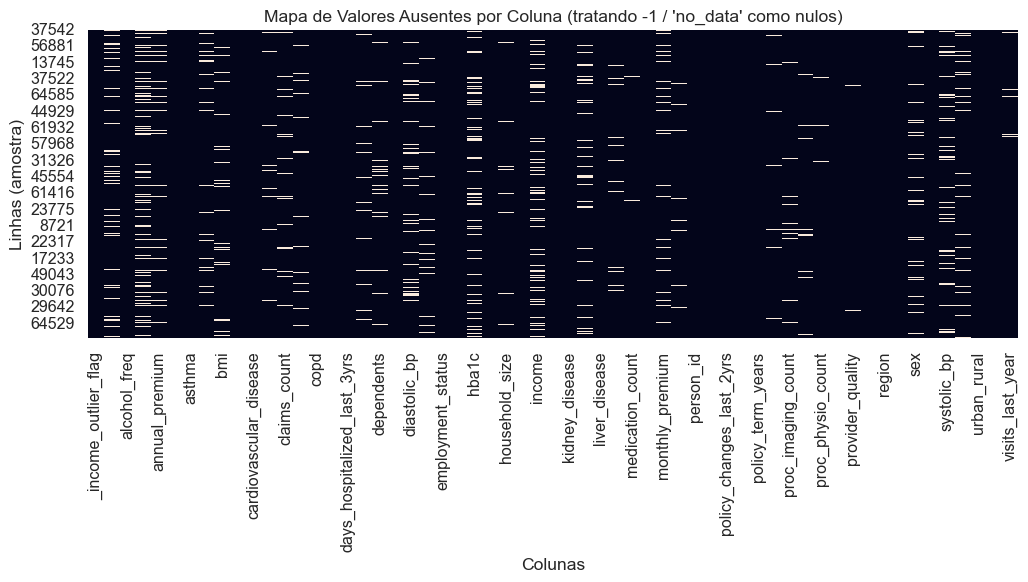

In [10]:

# === 9) Heatmap de ausentes (corrigido) ===
plot_missingness(df)


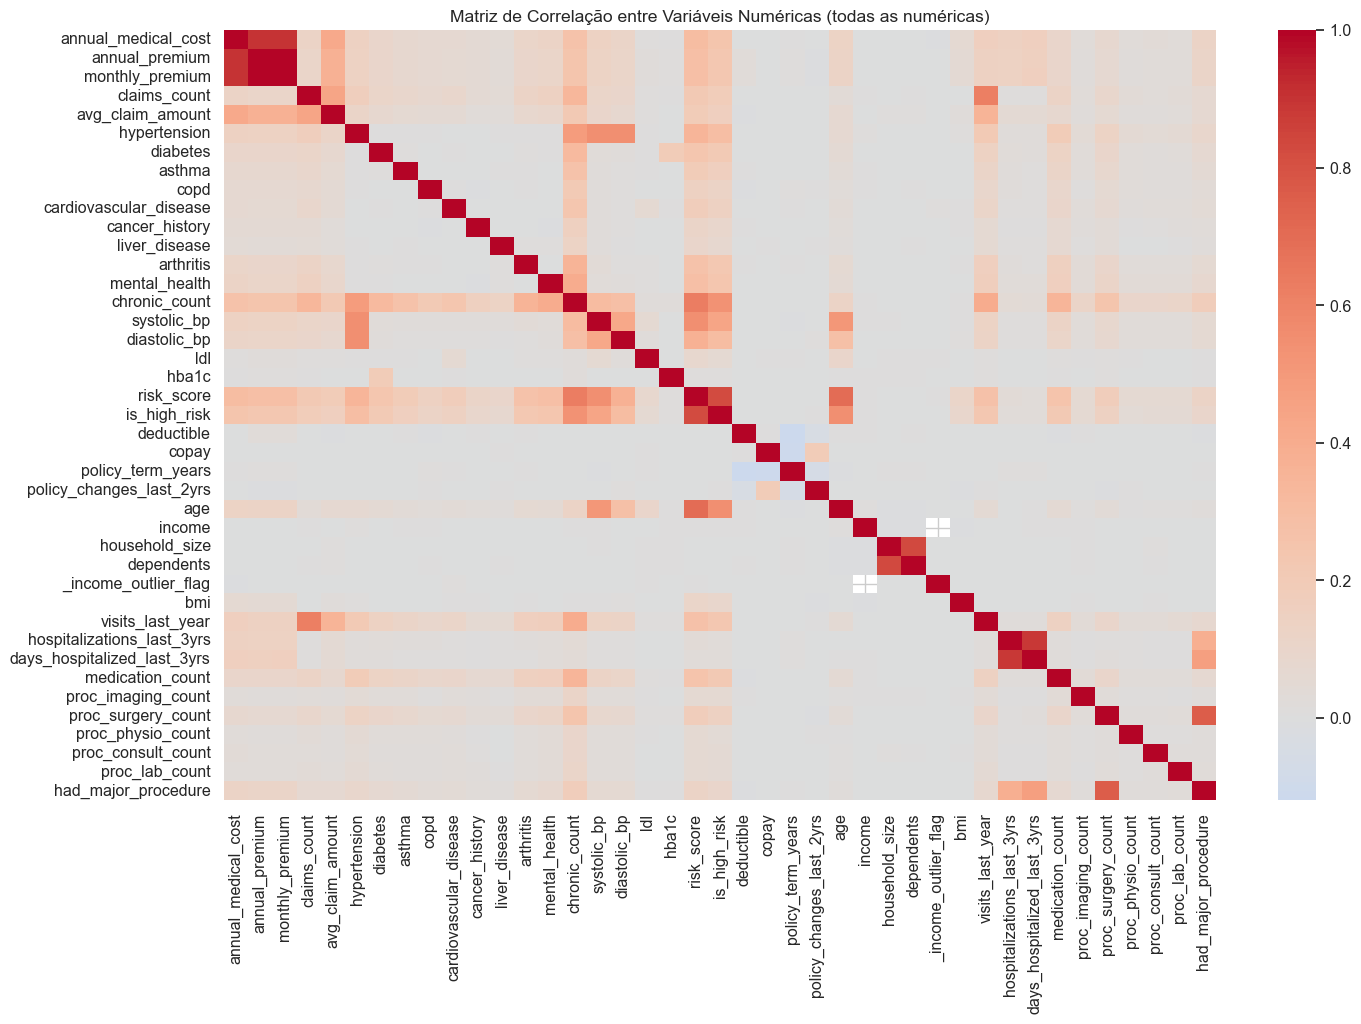

In [11]:

# === 10) Matriz de correlação (todas numéricas) ===
corr_full = plot_correlation_heatmap(df, drop_cols=id_like, title_suffix="(todas as numéricas)")


Alvo selecionado: annual_medical_cost

Top correlações absolutas com o alvo: annual_medical_cost
annual_premium                 0.903124
monthly_premium                0.903124
avg_claim_amount               0.422755
risk_score                     0.301832
chronic_count                  0.260763
is_high_risk                   0.244543
days_hospitalized_last_3yrs    0.160816
visits_last_year               0.157782
hospitalizations_last_3yrs     0.147697
hypertension                   0.146073
systolic_bp                    0.137147
age                            0.128724
mental_health                  0.118813
claims_count                   0.118043
had_major_procedure            0.117592
Name: annual_medical_cost, dtype: float64


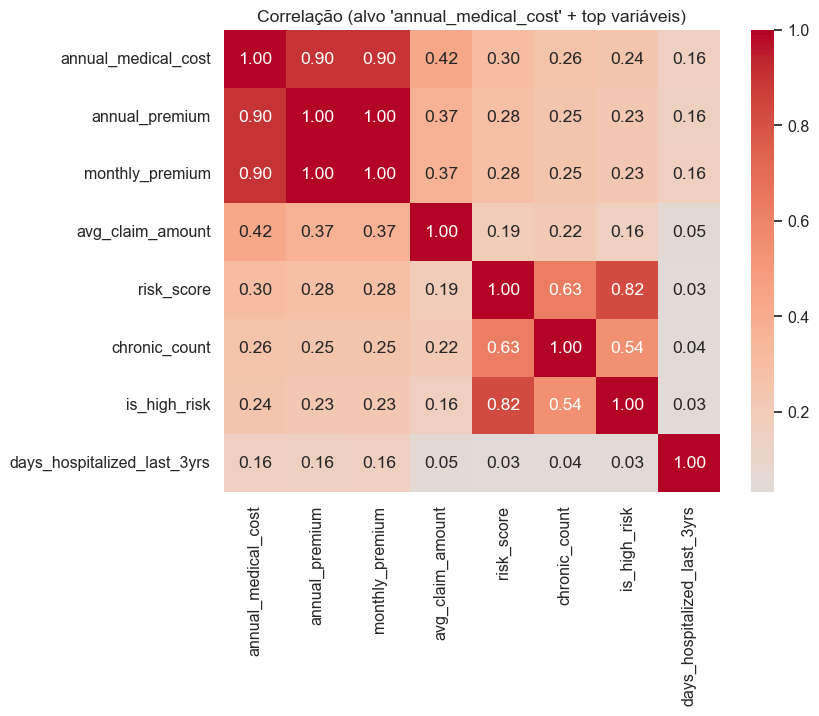

In [12]:

# === 11) Alvo escolhido + heatmap focado ===
target = pick_target(df, TARGET_CANDIDATES)
print(f"Alvo selecionado: {target}")
if target:
    top_vars = plot_top_corr_with_target(corr_full, target, topn=15)
    focus_cols = [target] + top_vars[:MAX_PAIRPLOT_VARS-1]
    focus_corr = df[focus_cols].corr(numeric_only=True)
    plt.figure(figsize=(8, 6))
    sns.heatmap(focus_corr, cmap="coolwarm", center=0, annot=True, fmt=".2f")
    plt.title(tight_title(f"Correlação (alvo '{target}' + top variáveis)"))
    savefig_maybe("02b_corr_heatmap_target_focus")
    plt.show()


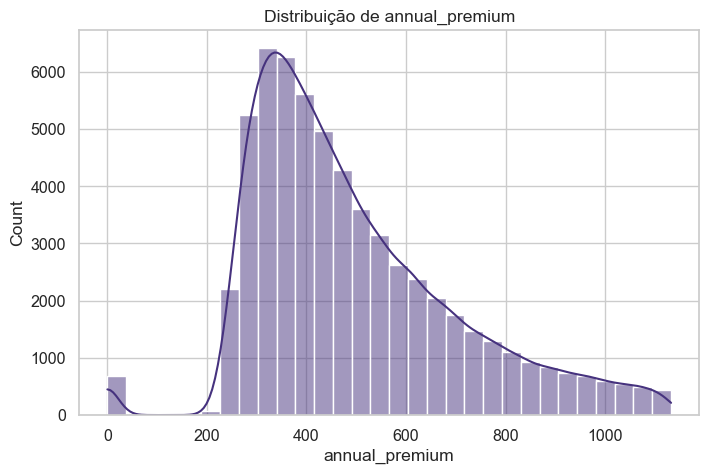

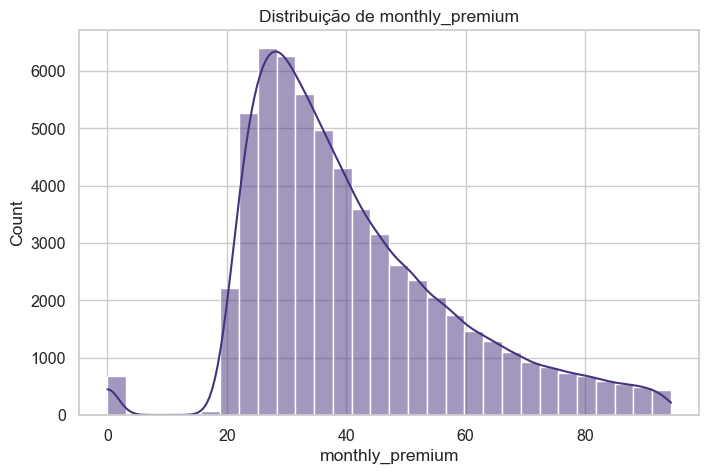

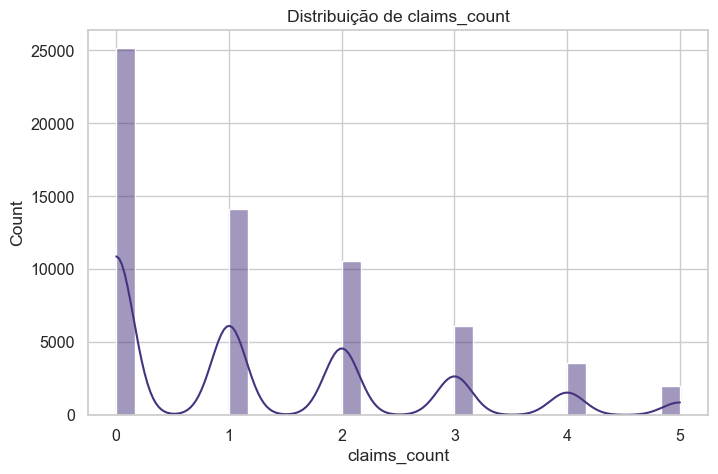

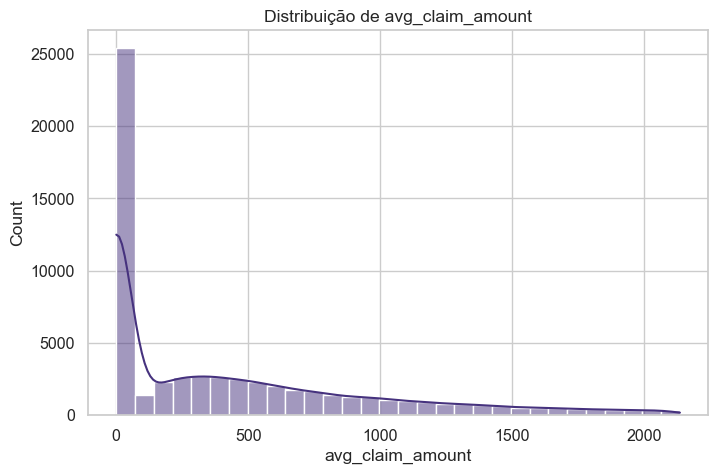

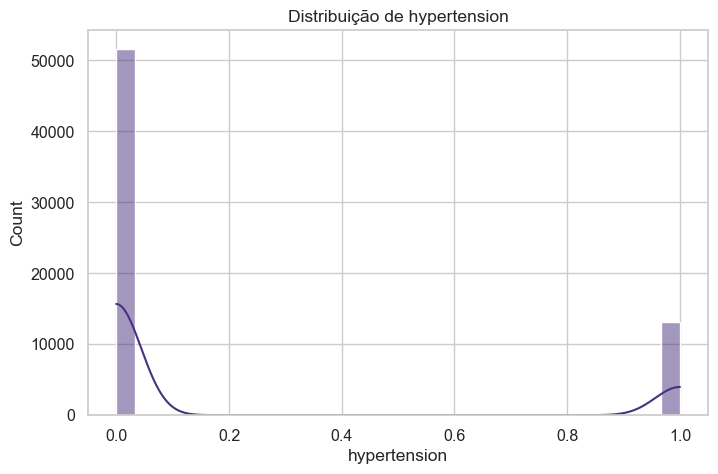

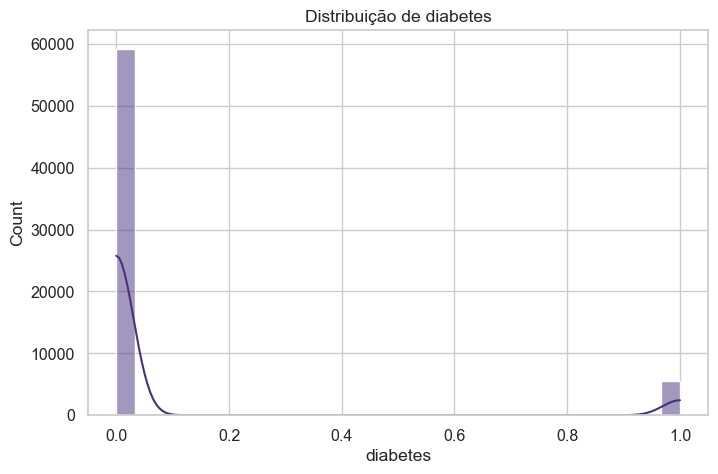

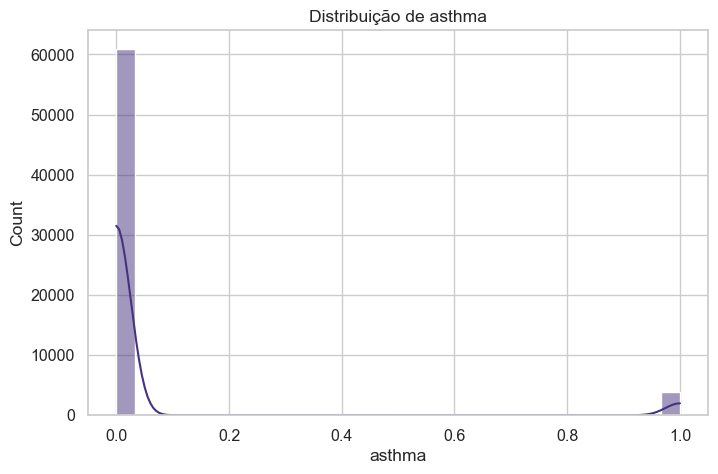

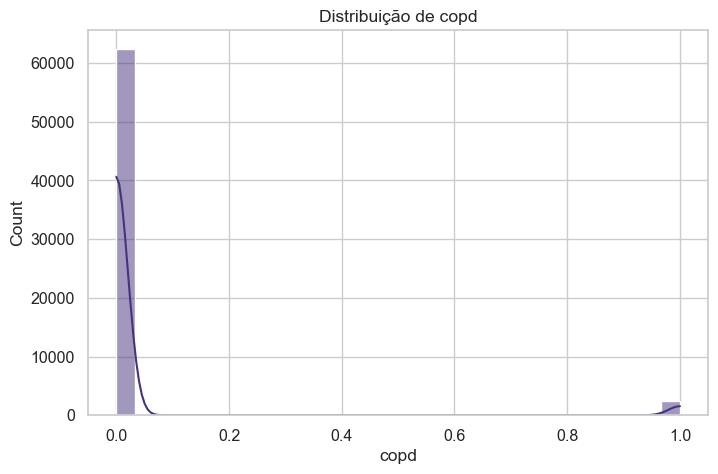

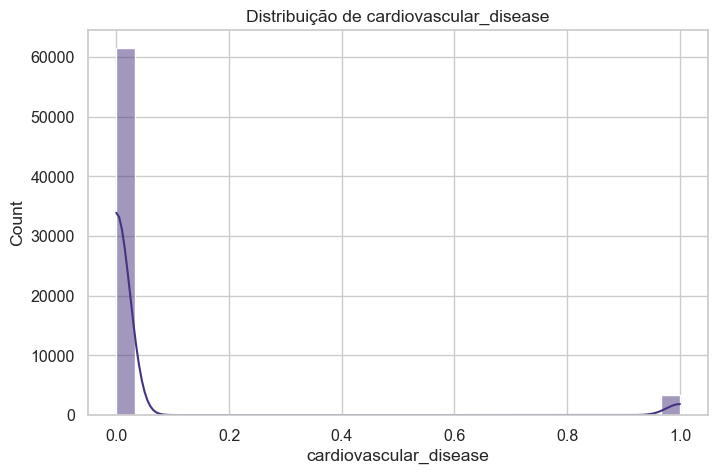

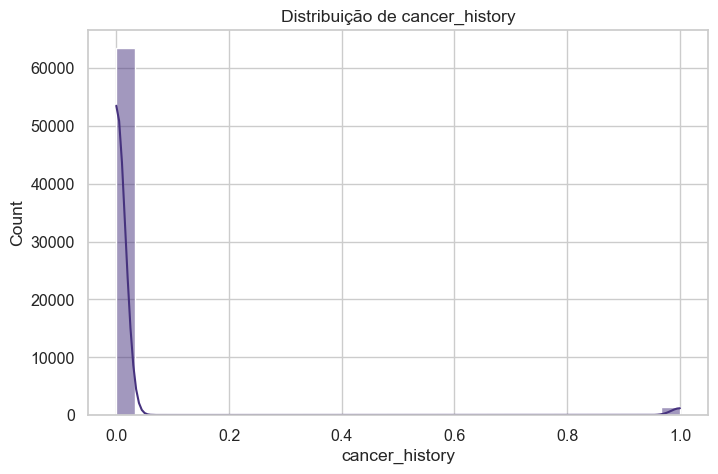

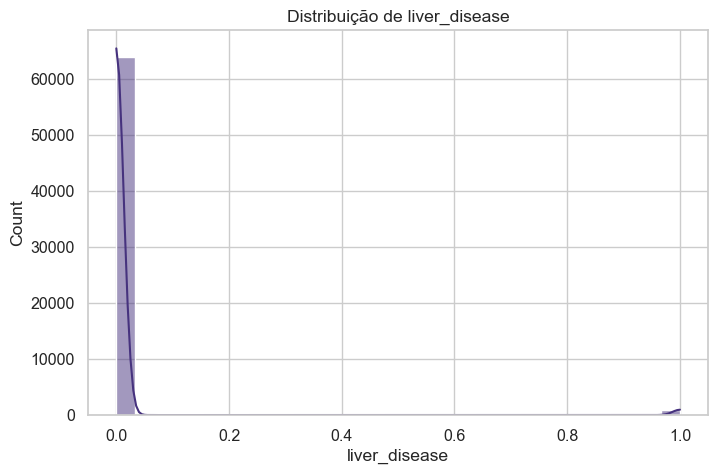

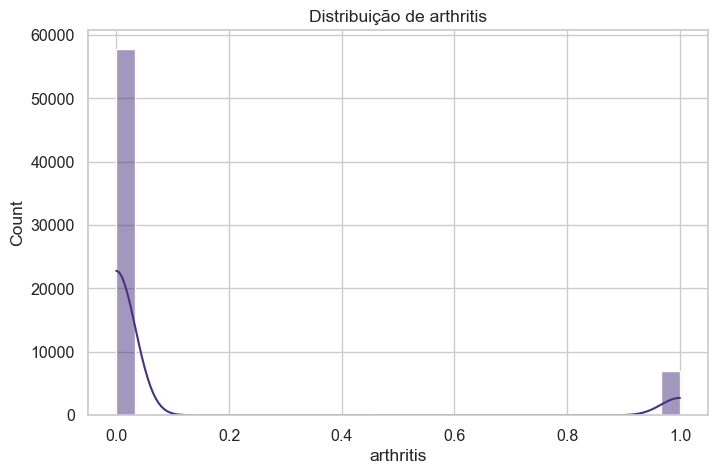

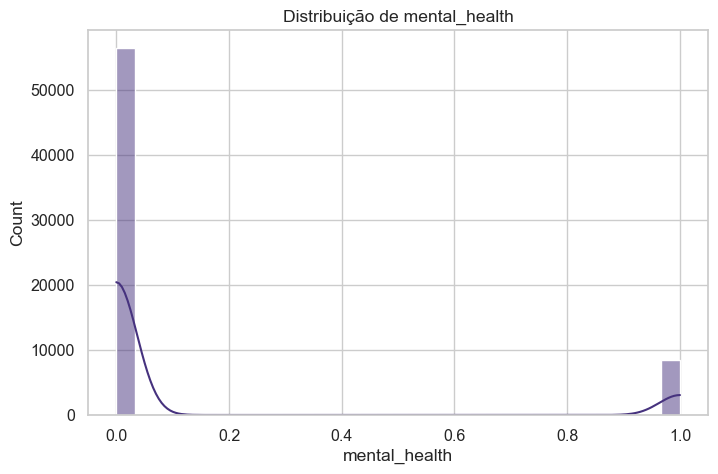

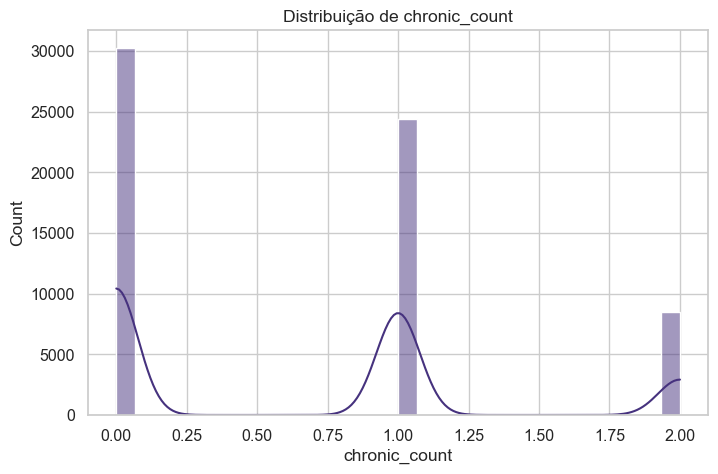

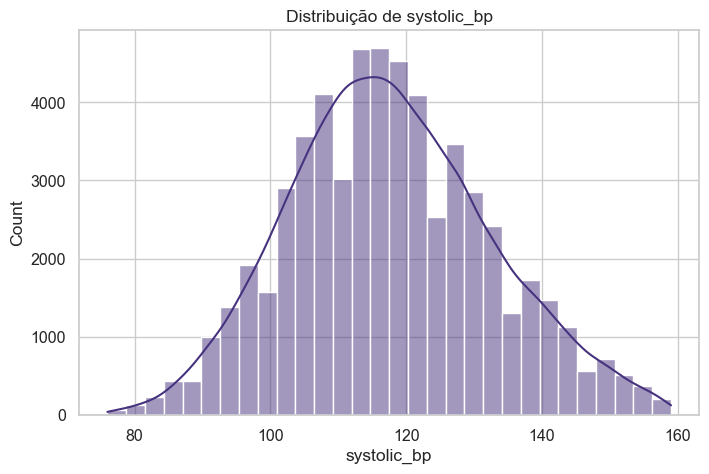

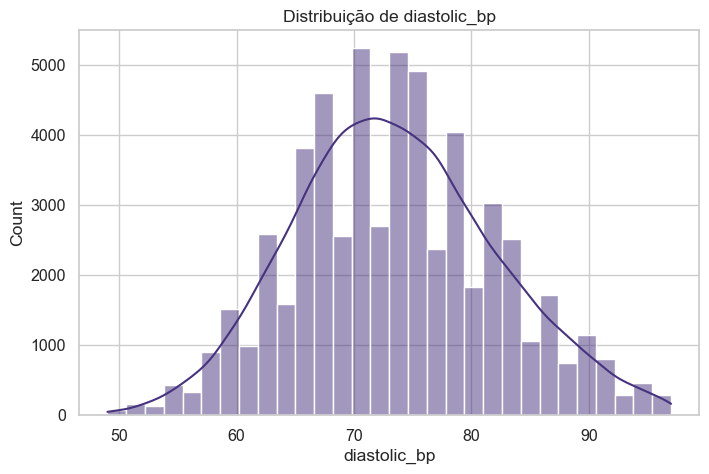

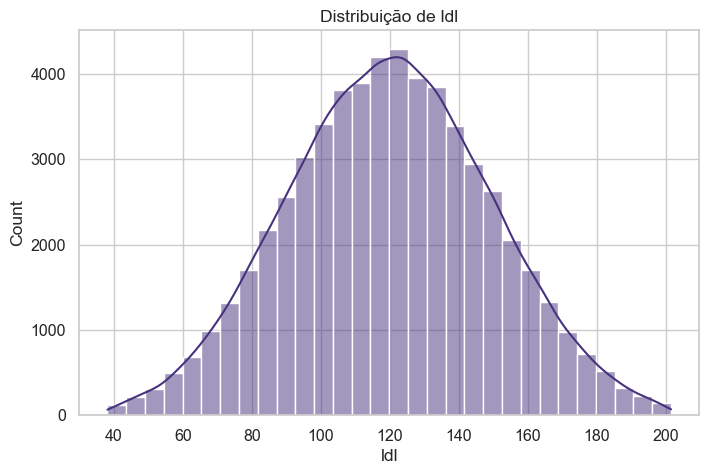

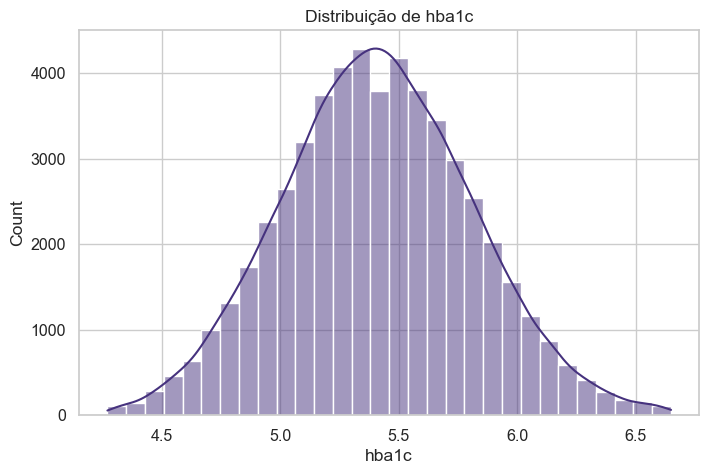

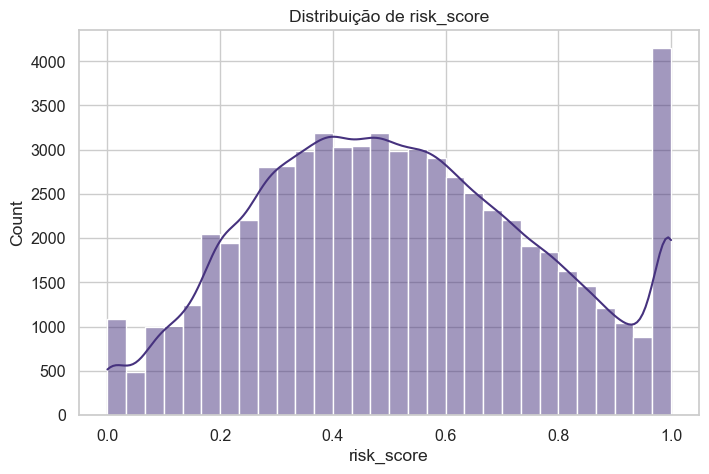

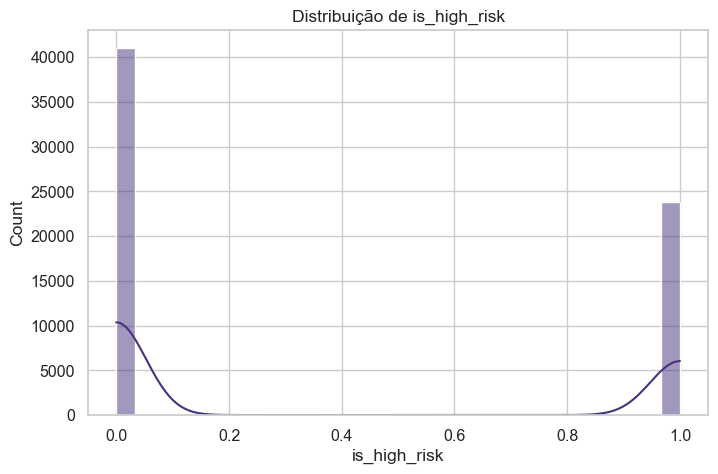

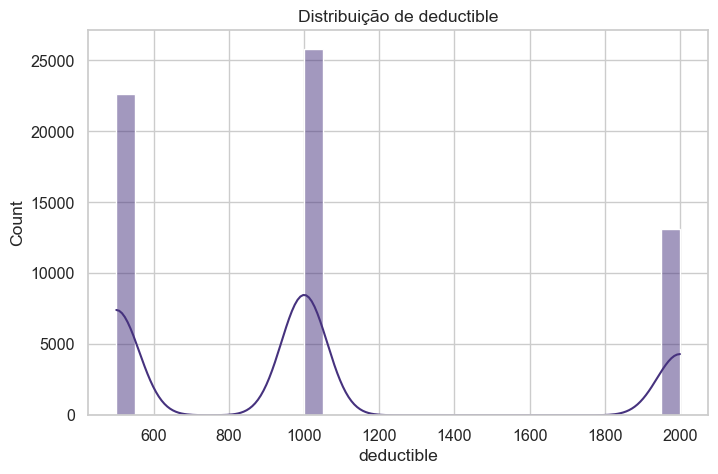

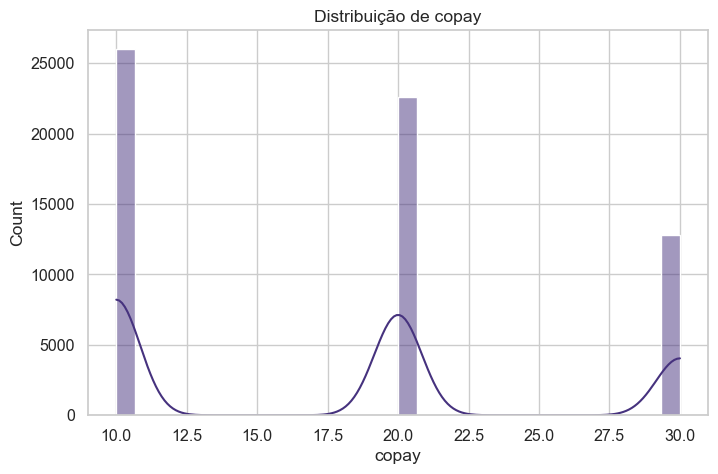

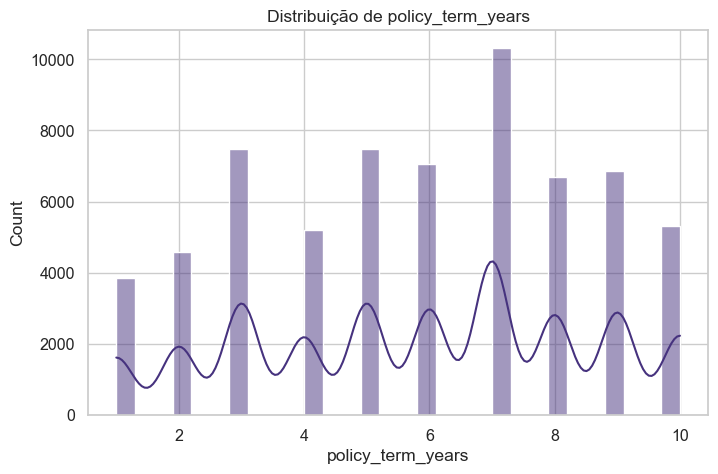

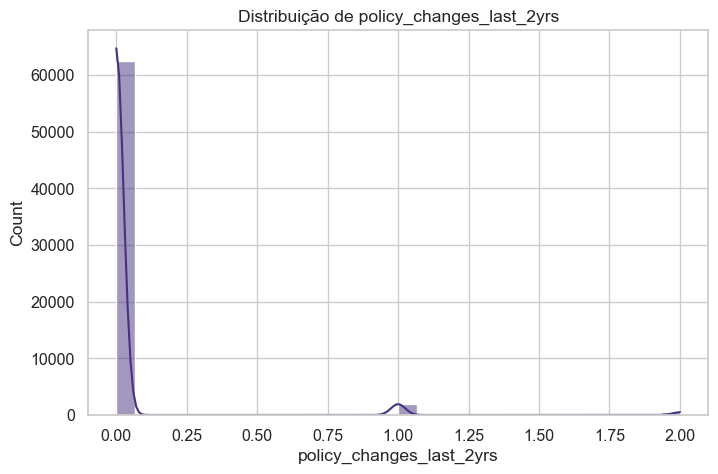

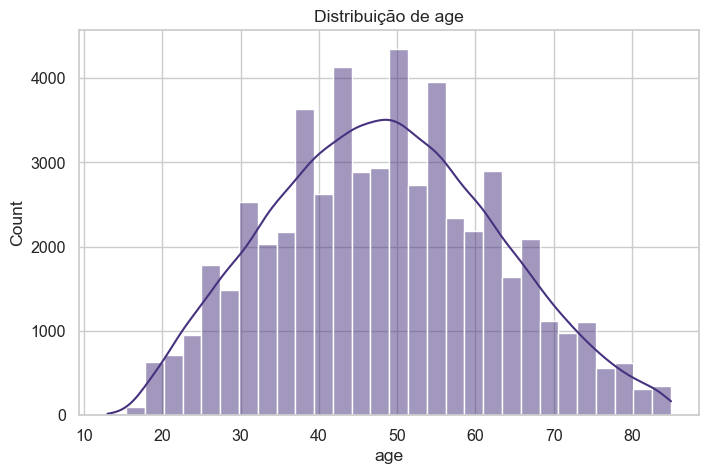

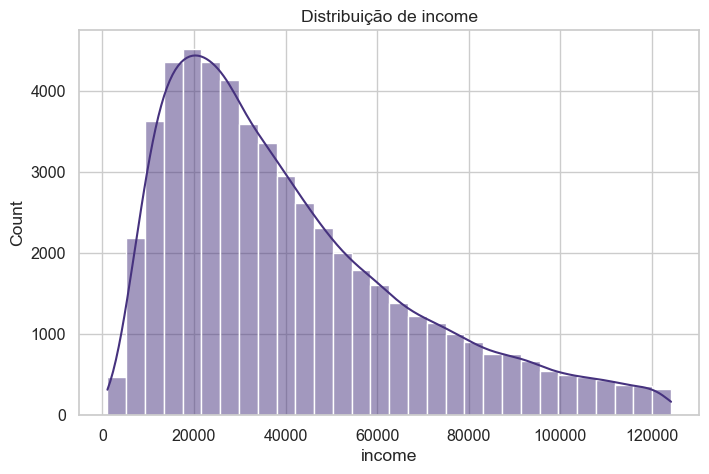

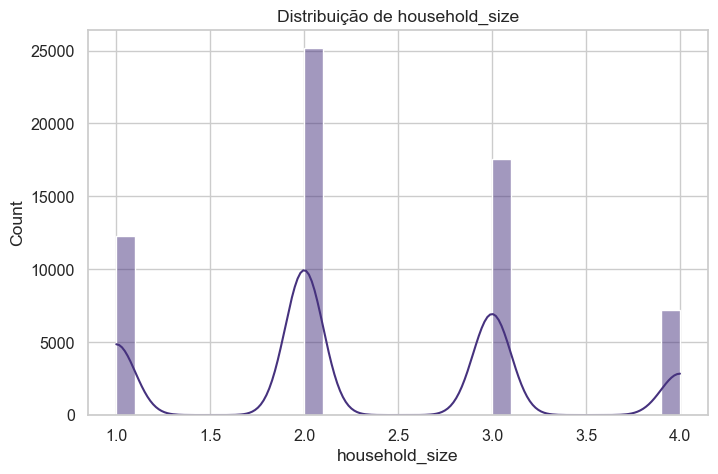

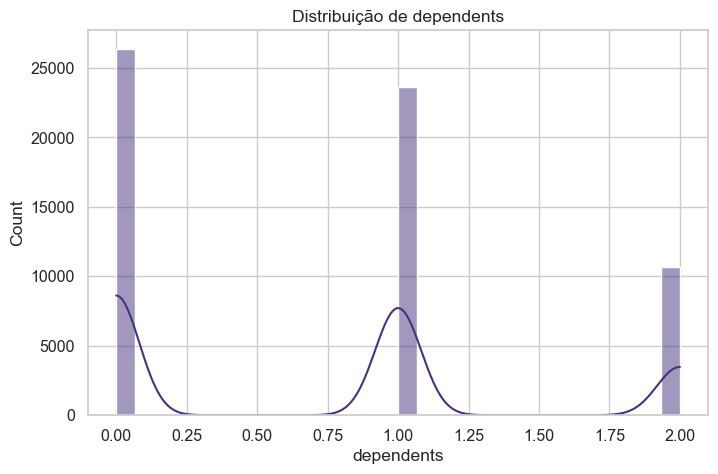

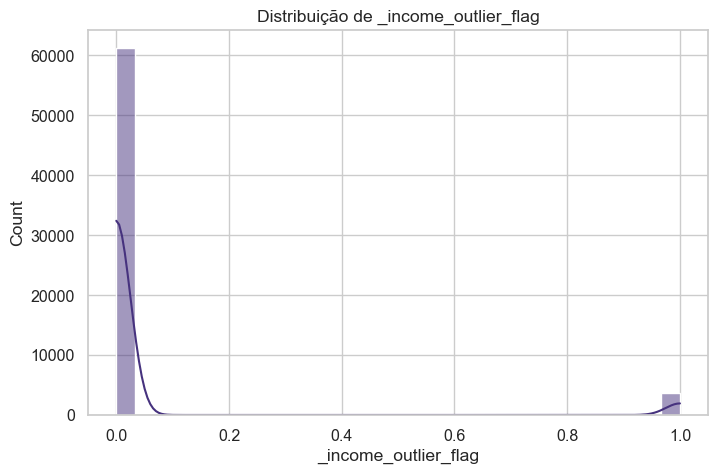

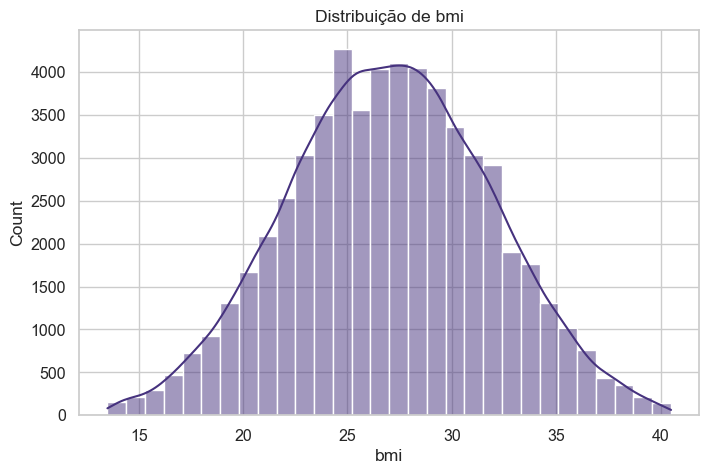

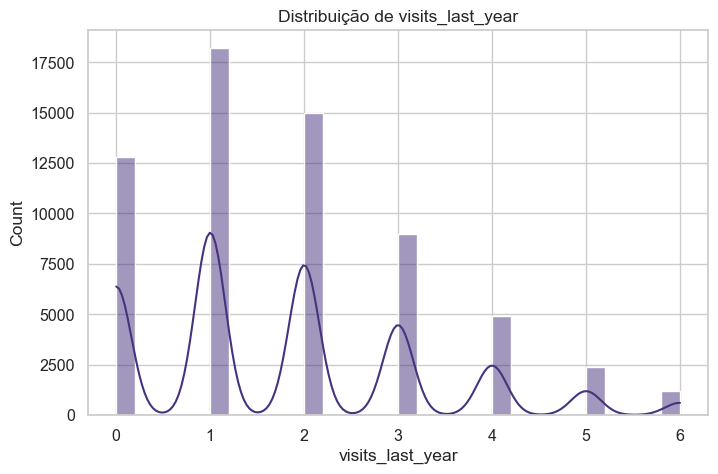

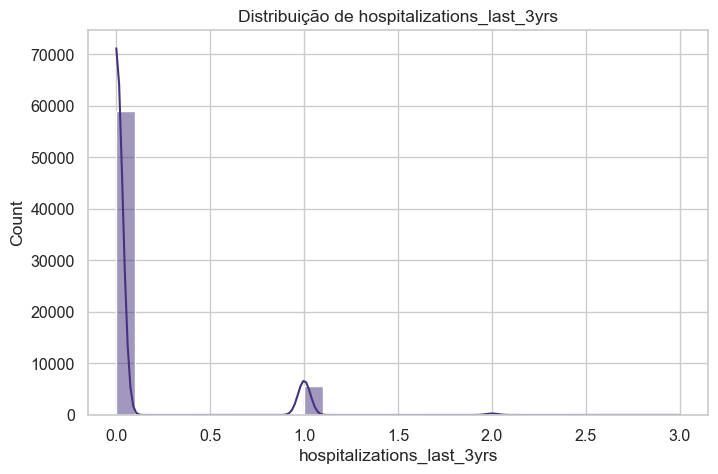

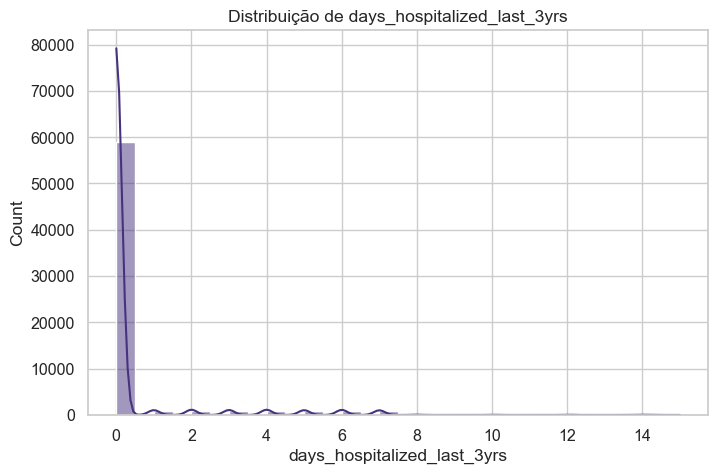

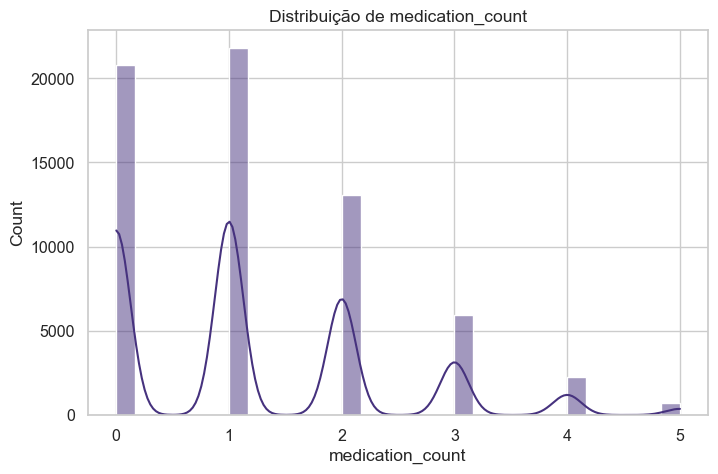

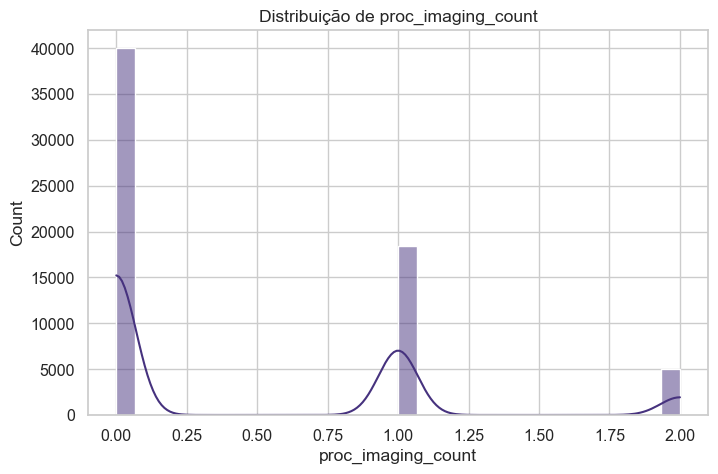

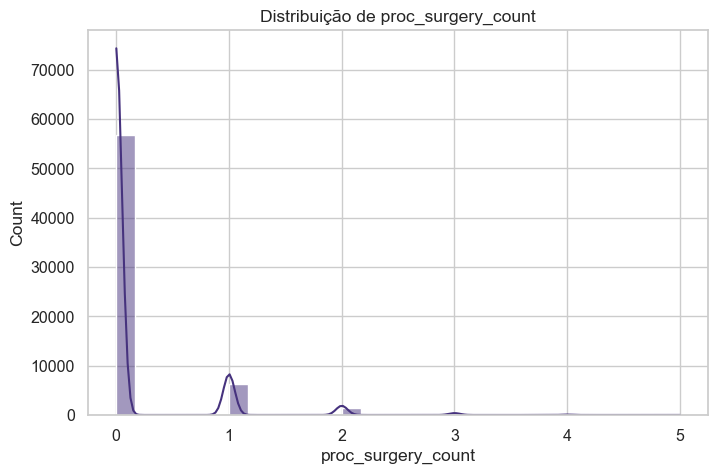

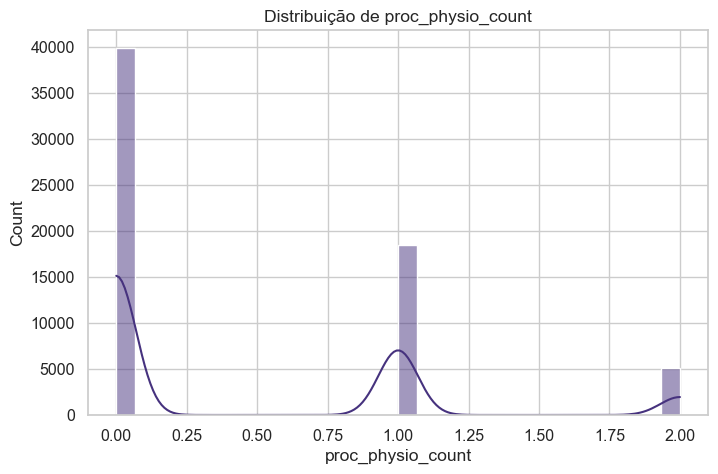

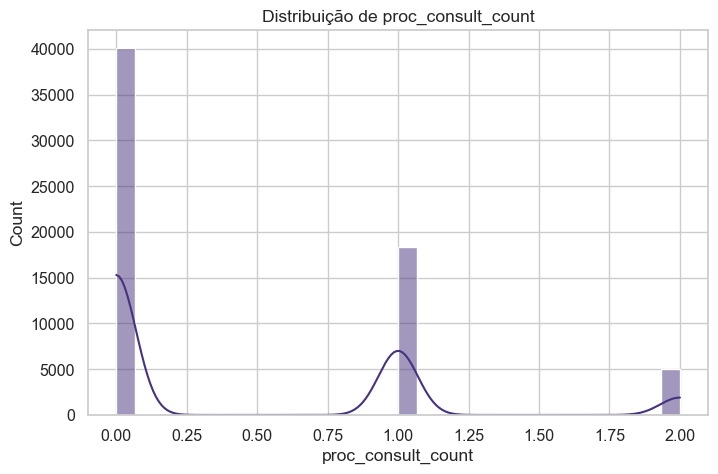

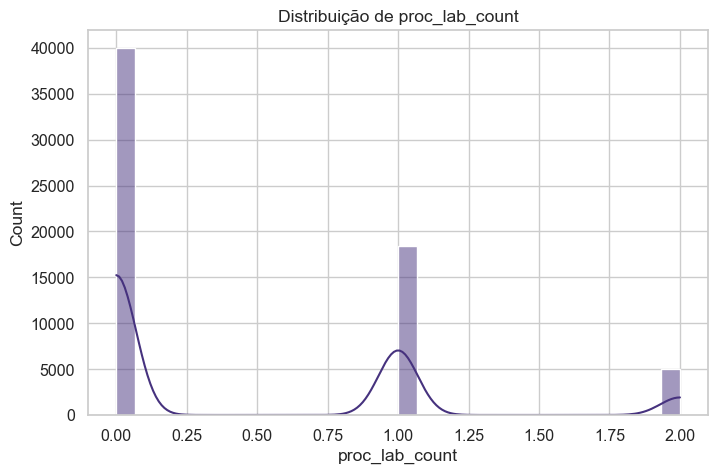

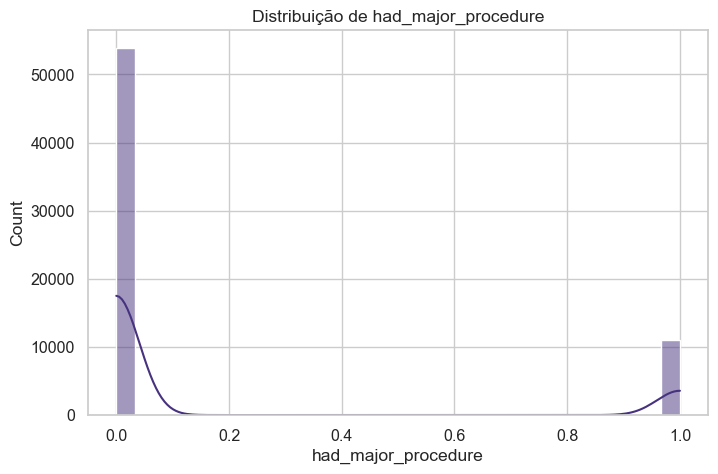

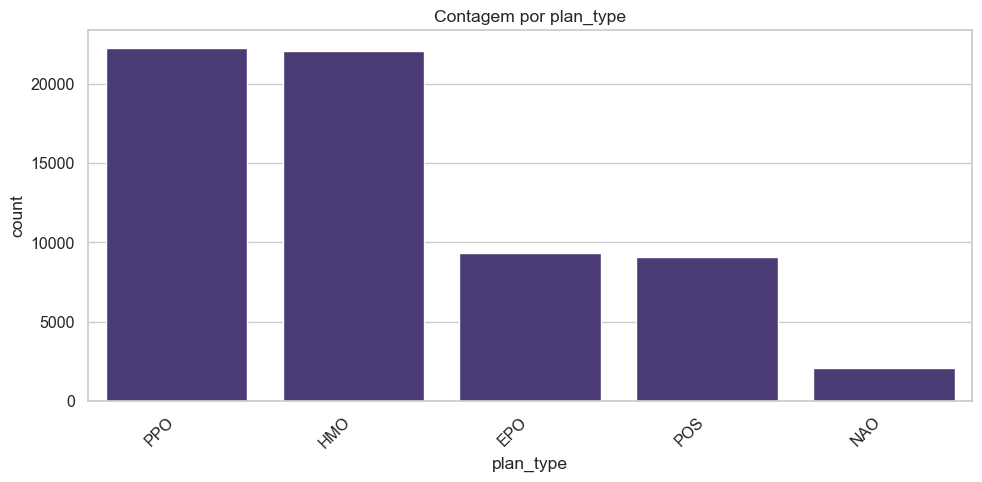

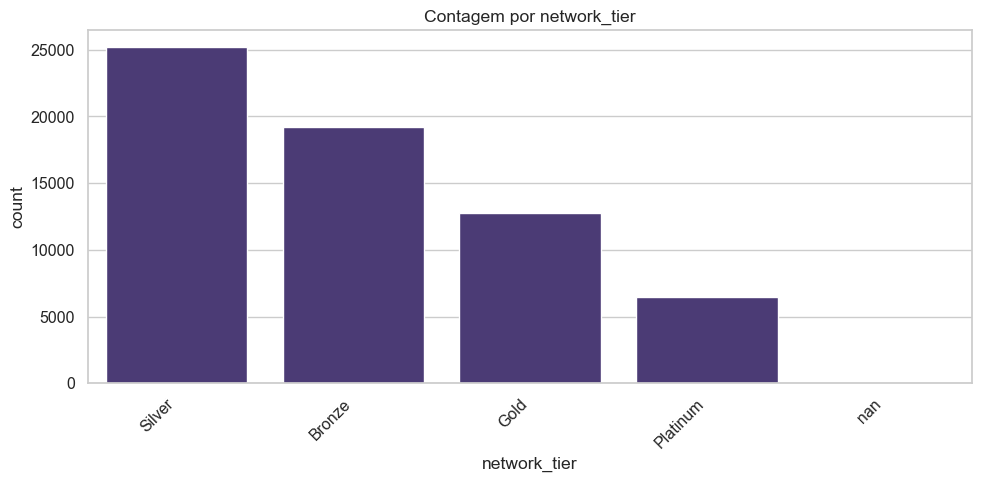

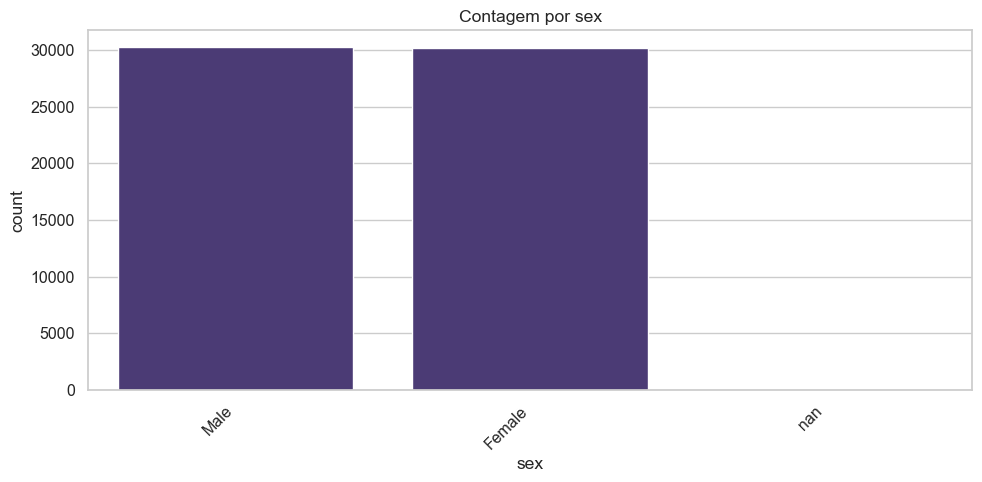

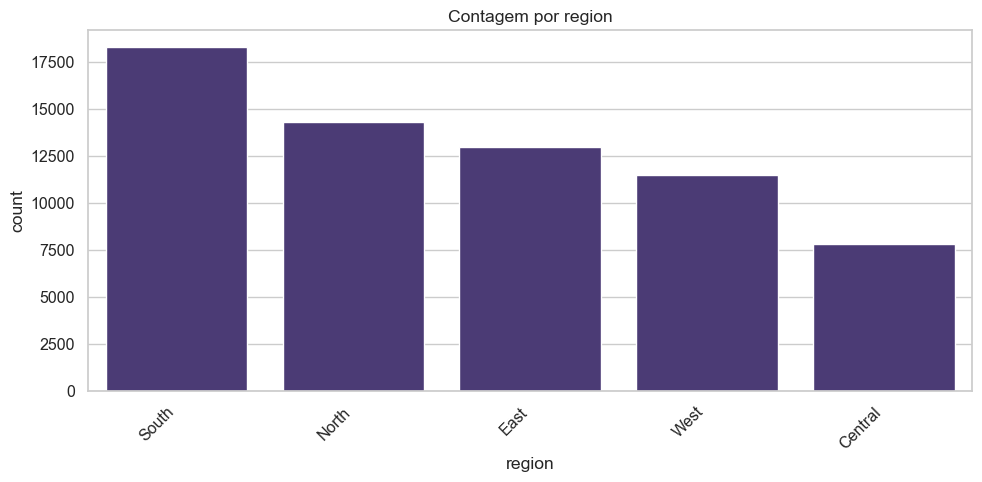

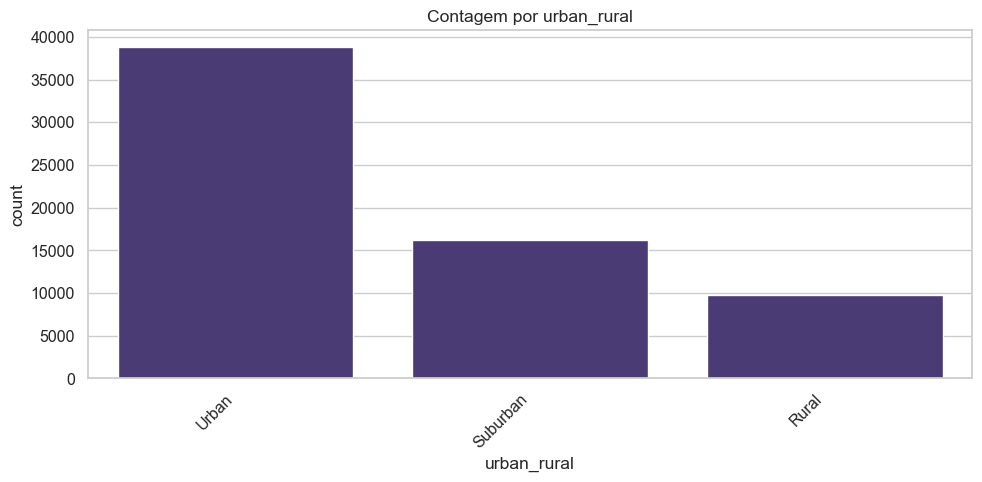

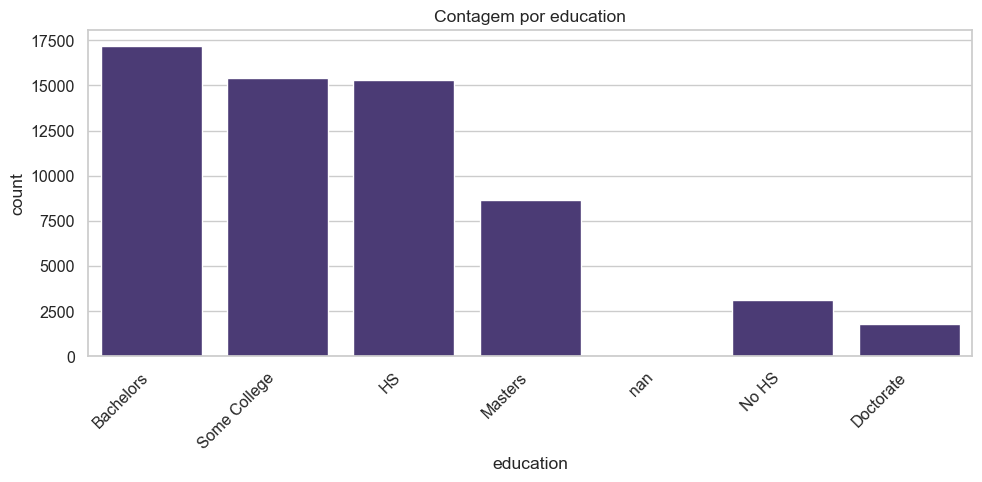

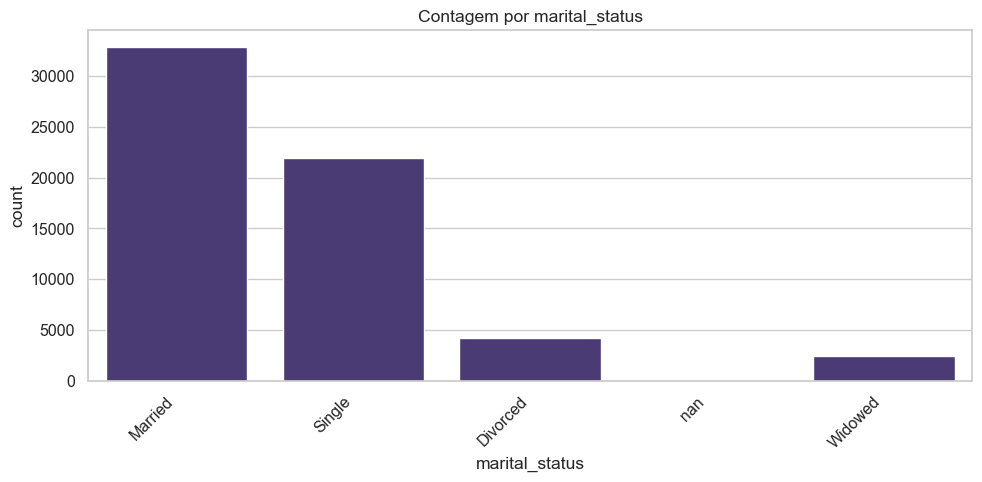

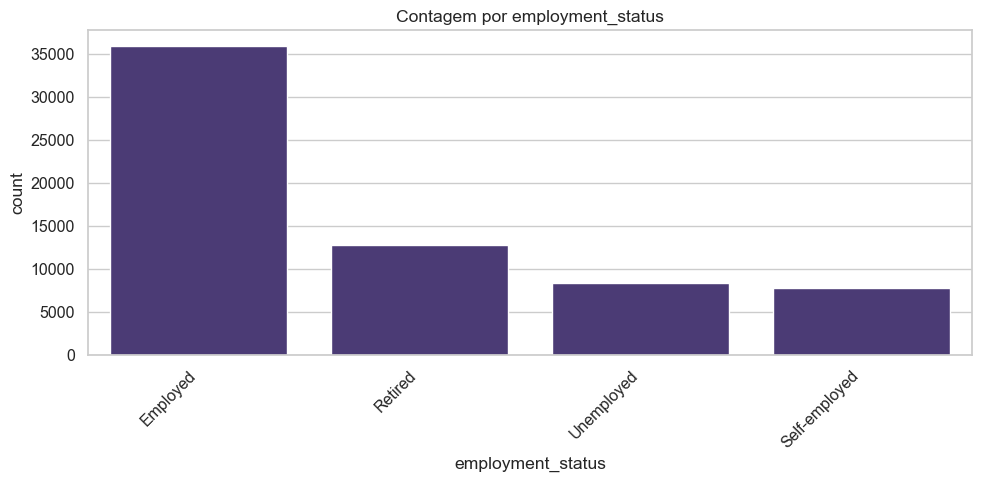

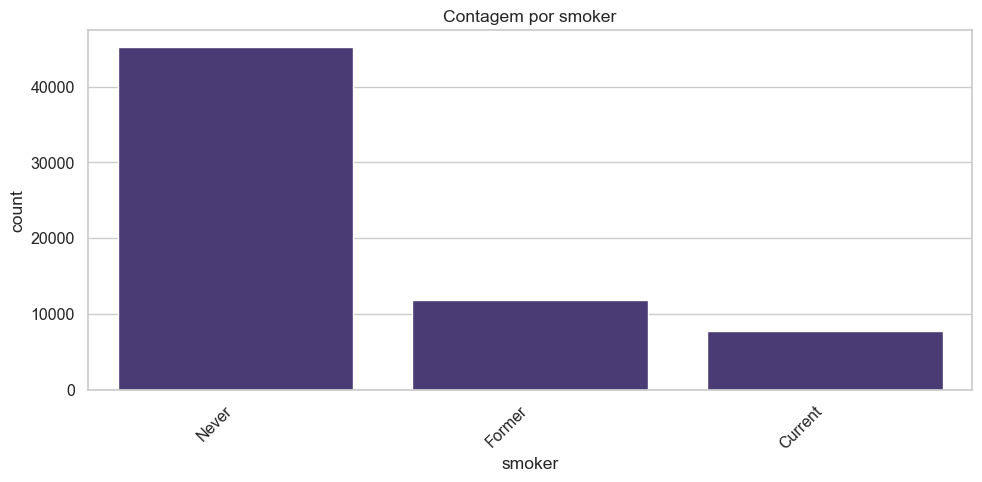

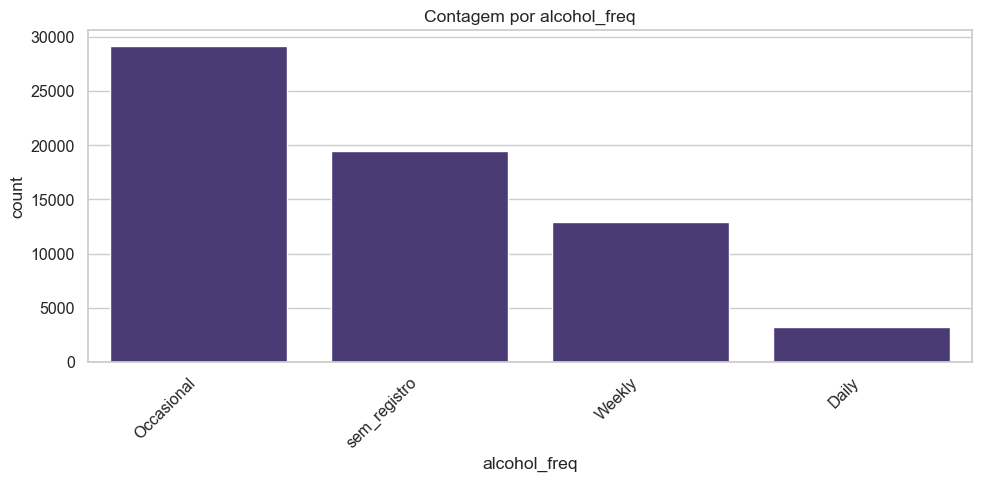

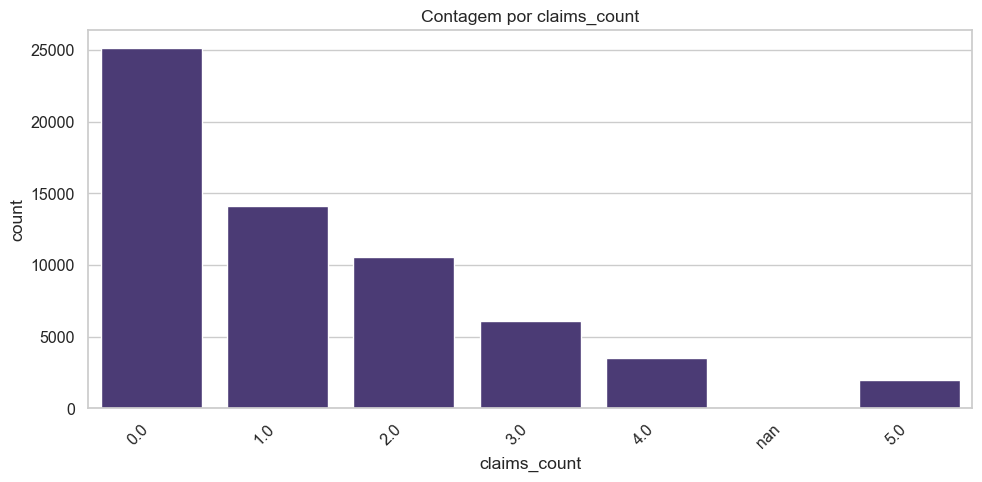

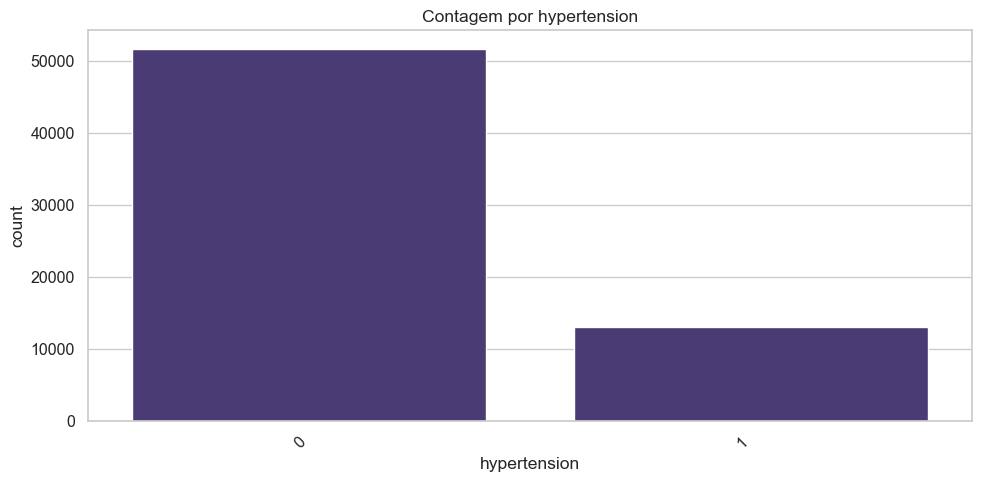

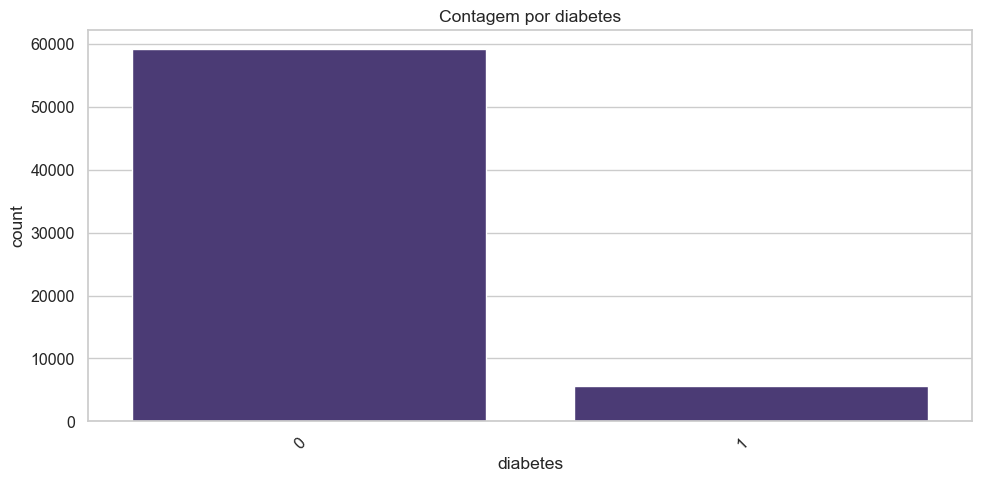

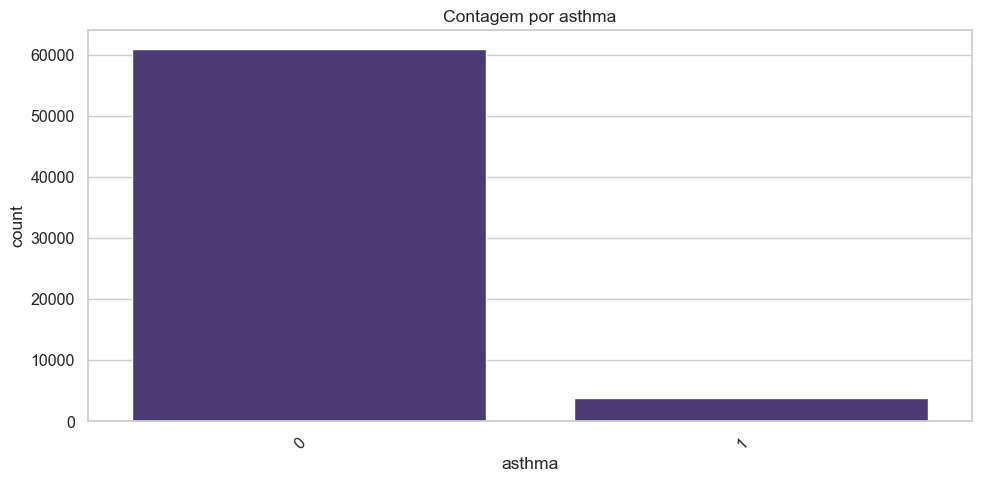

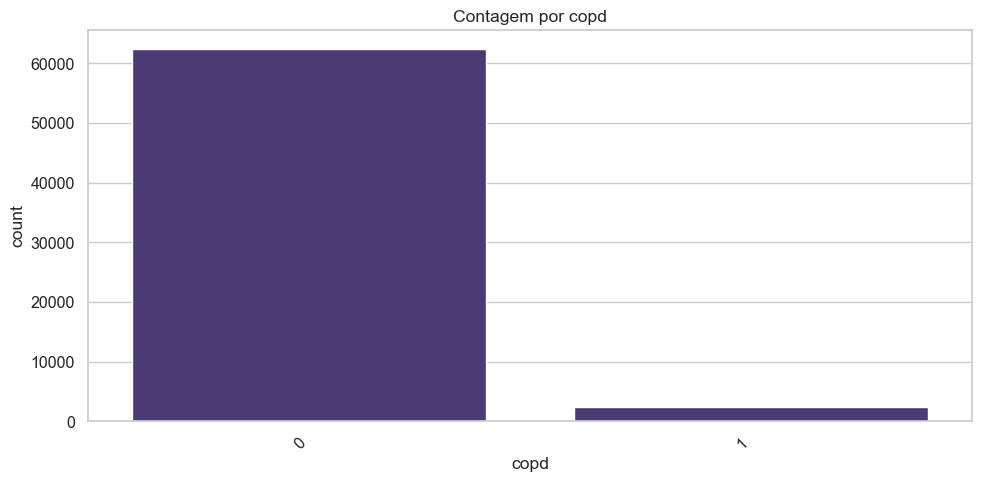

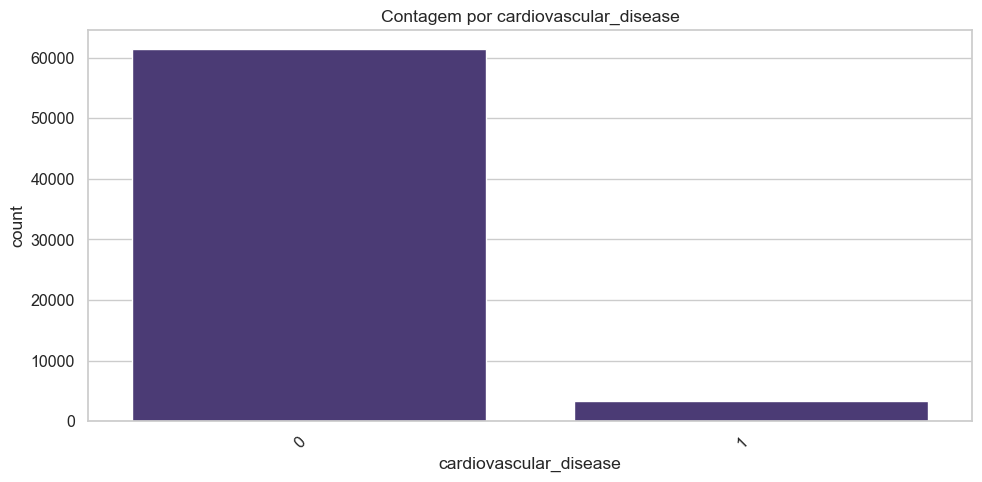

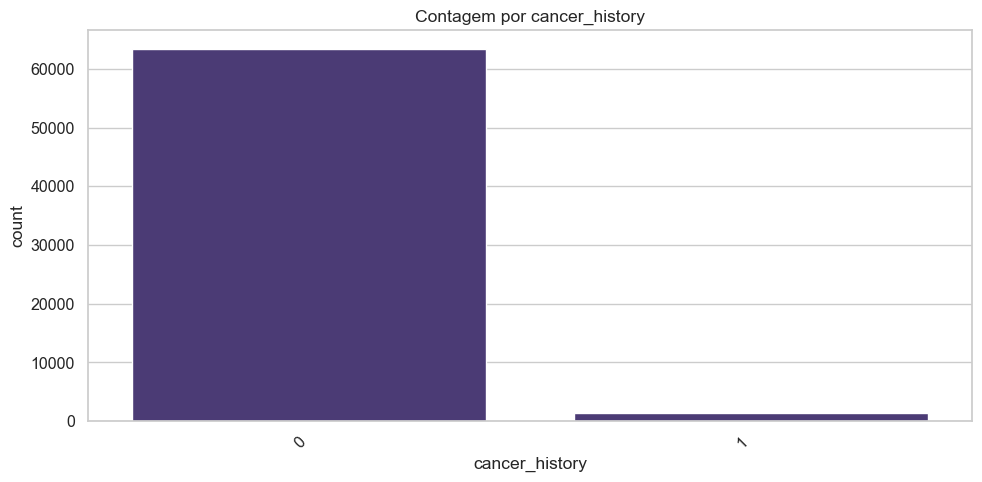

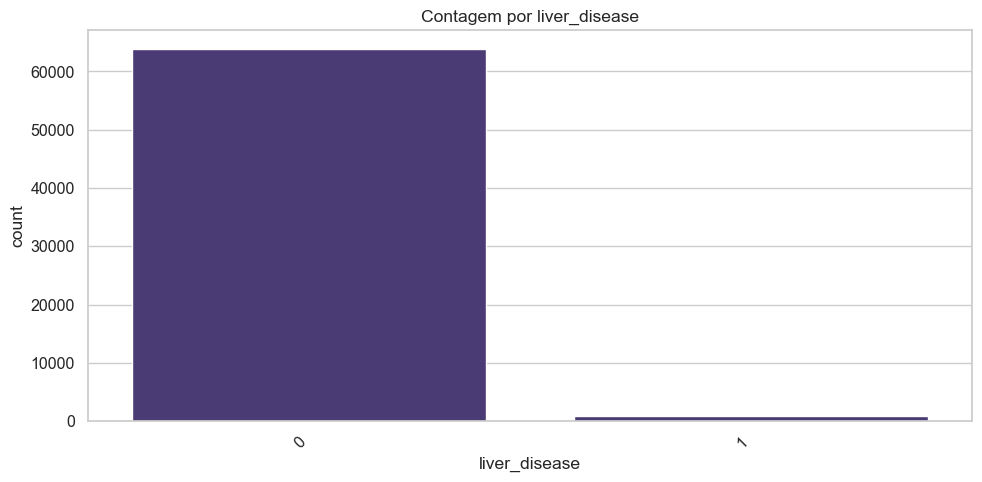

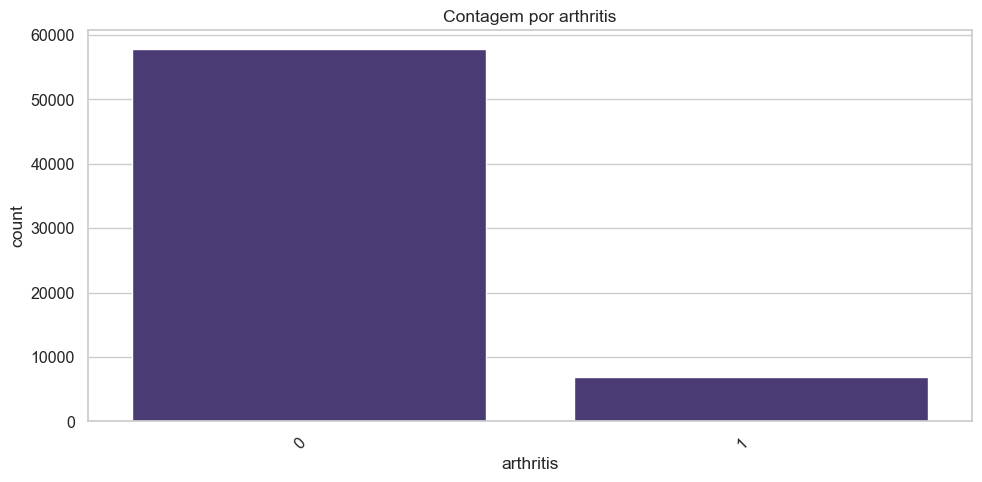

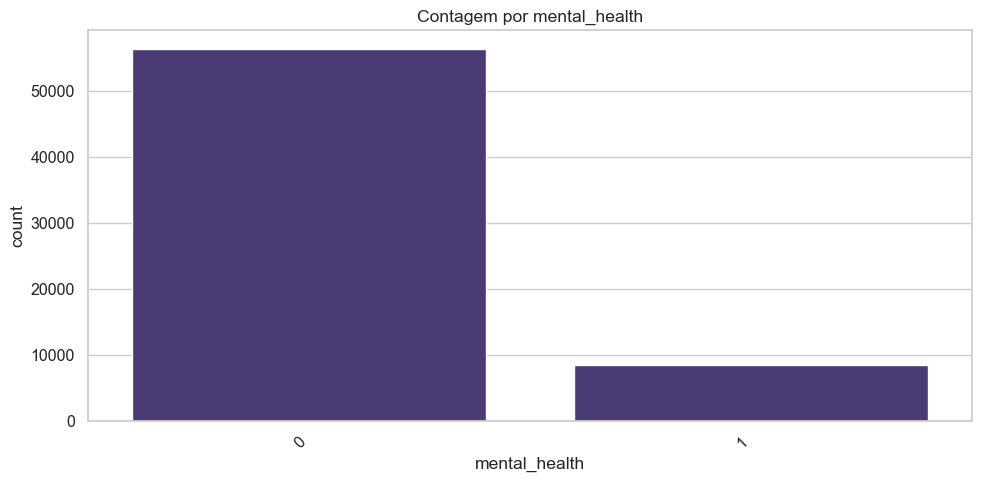

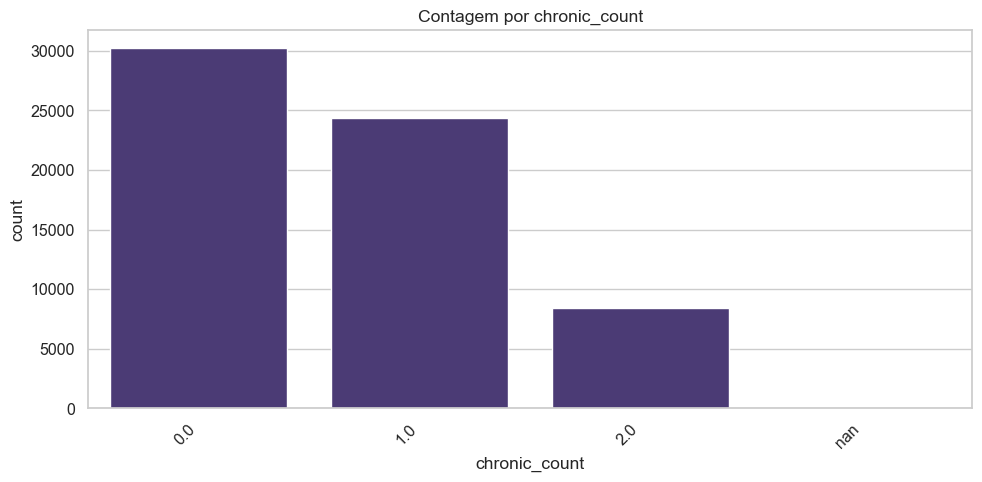

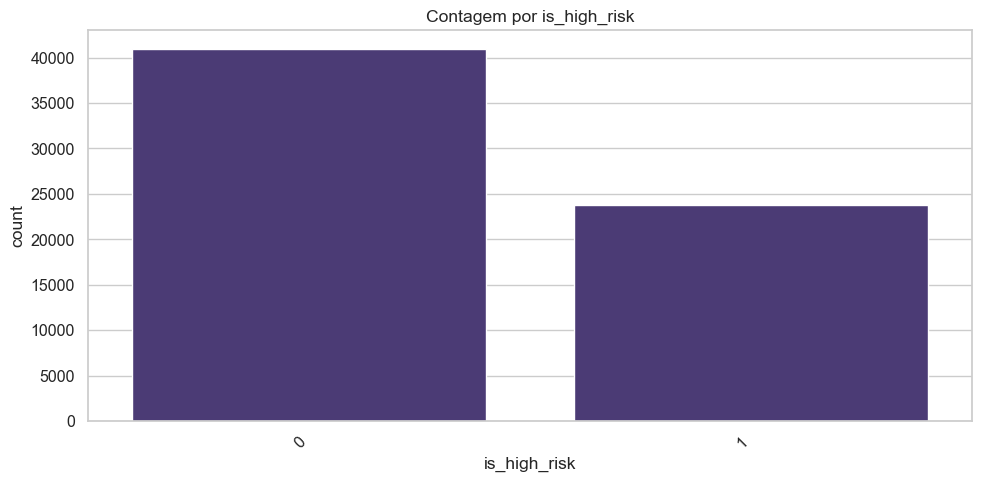

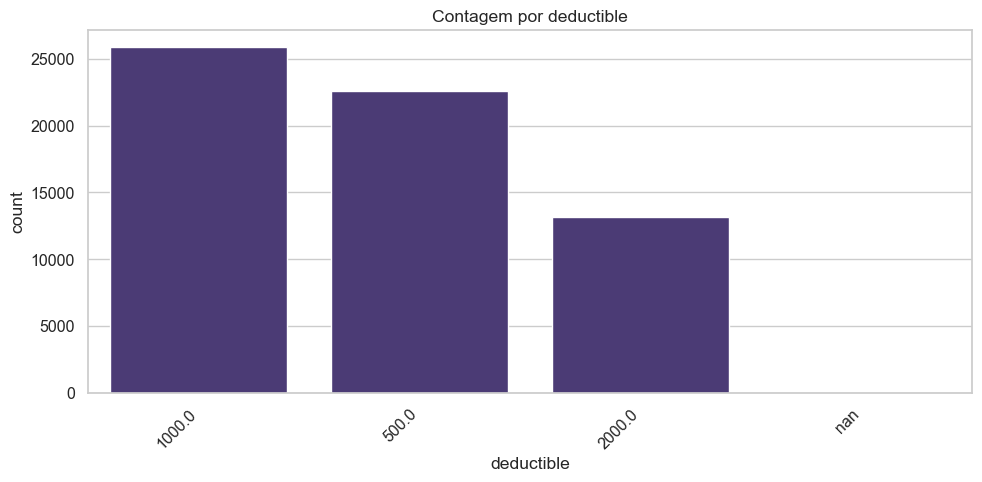

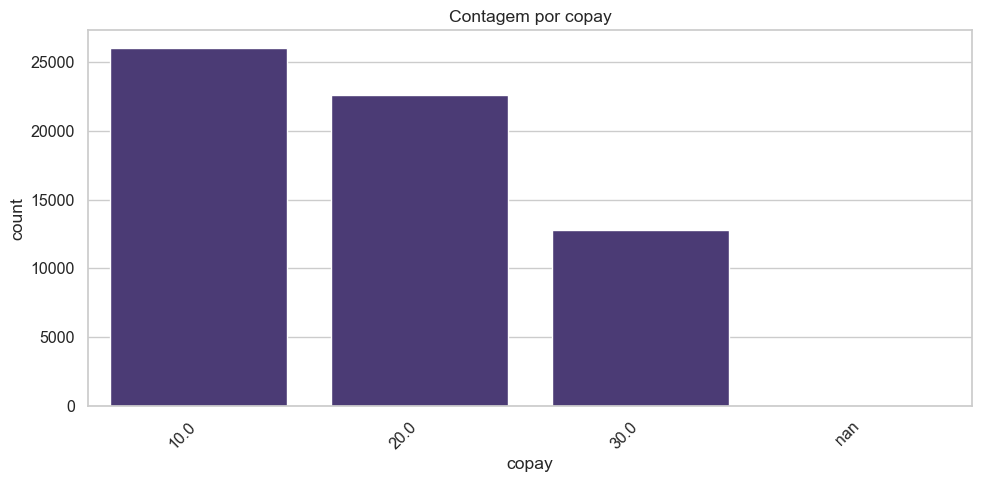

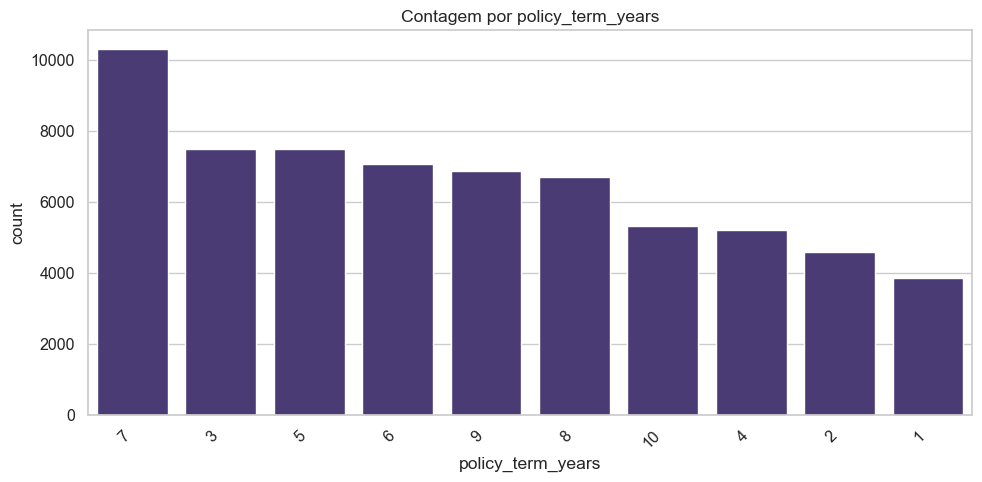

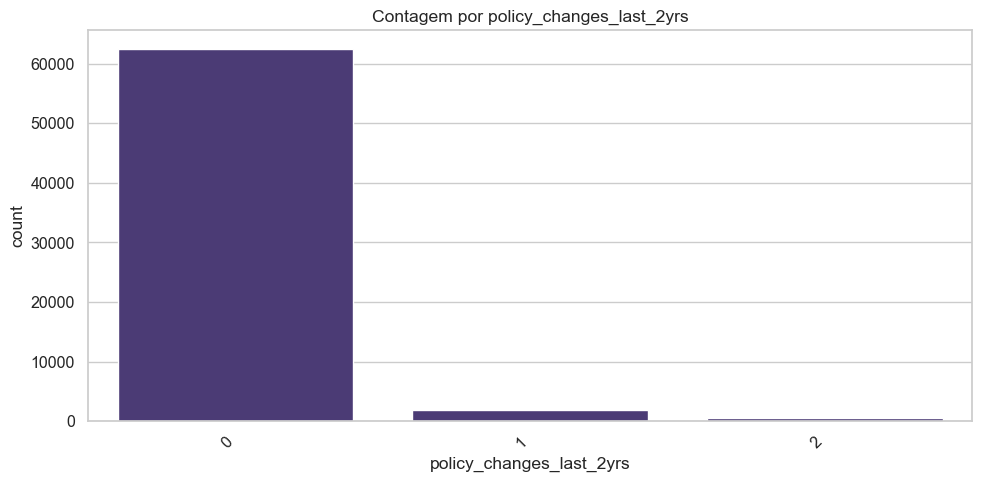

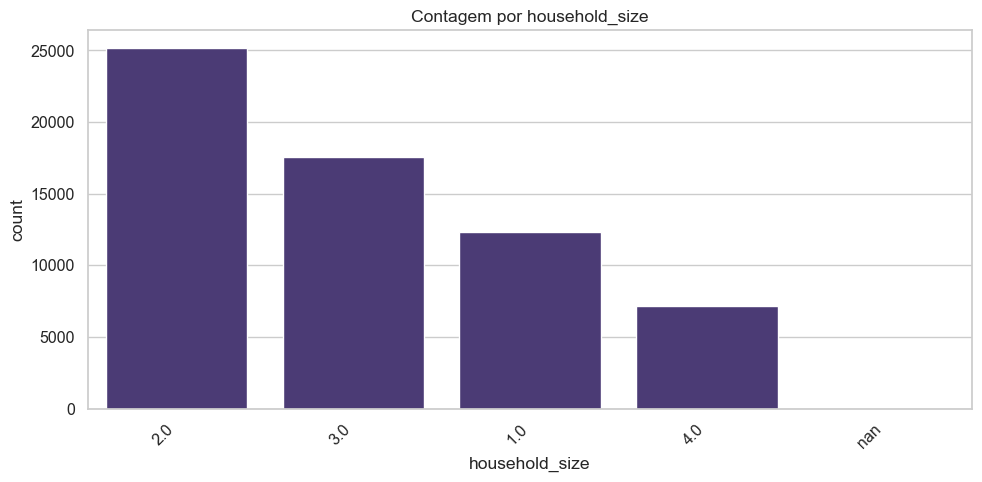

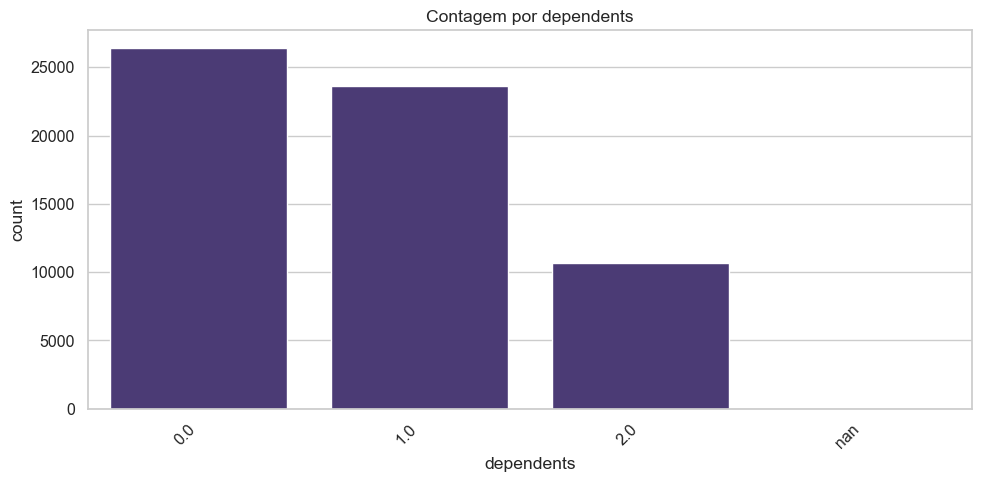

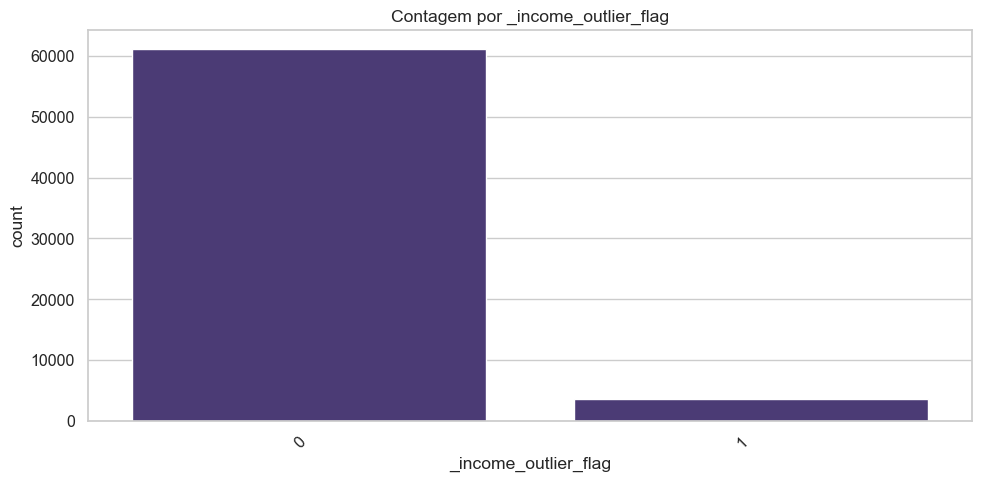

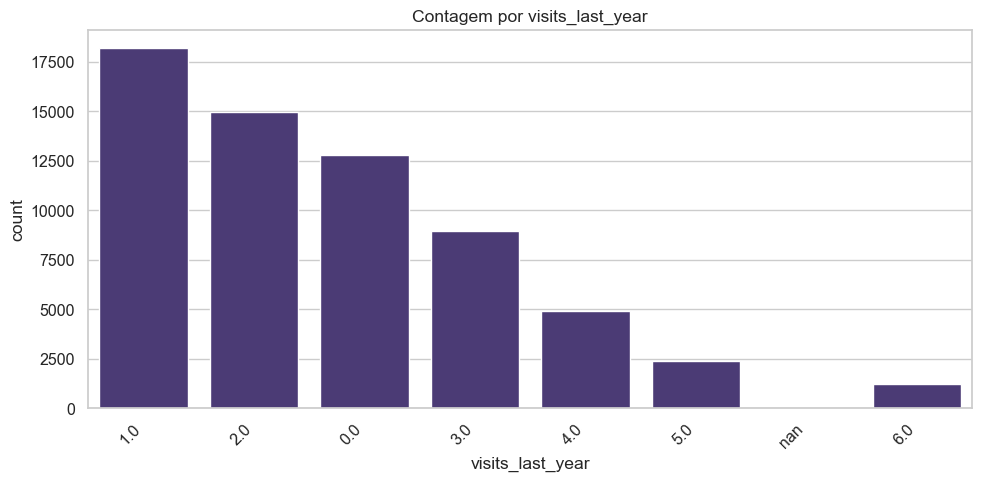

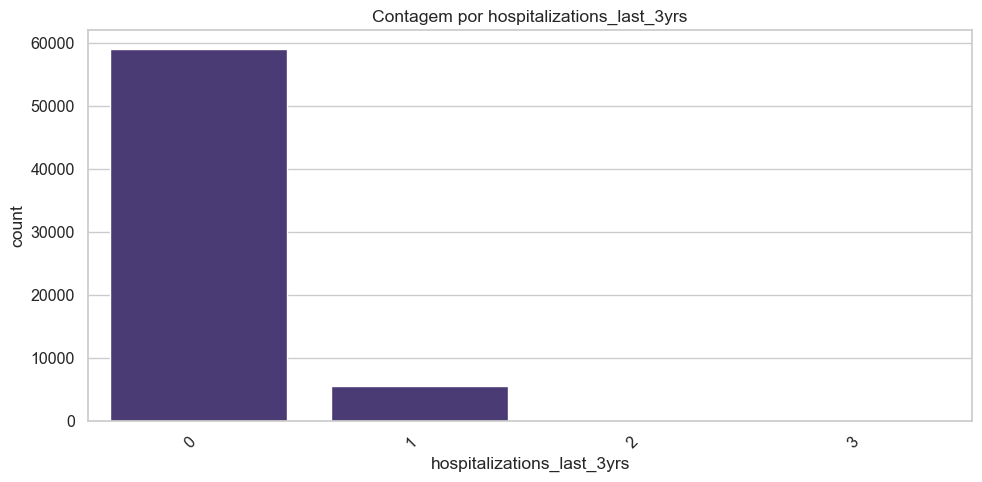

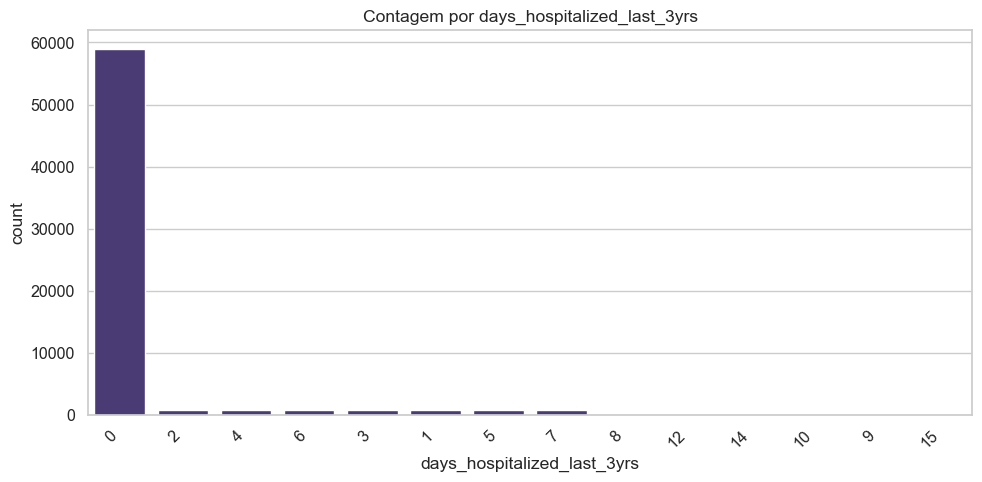

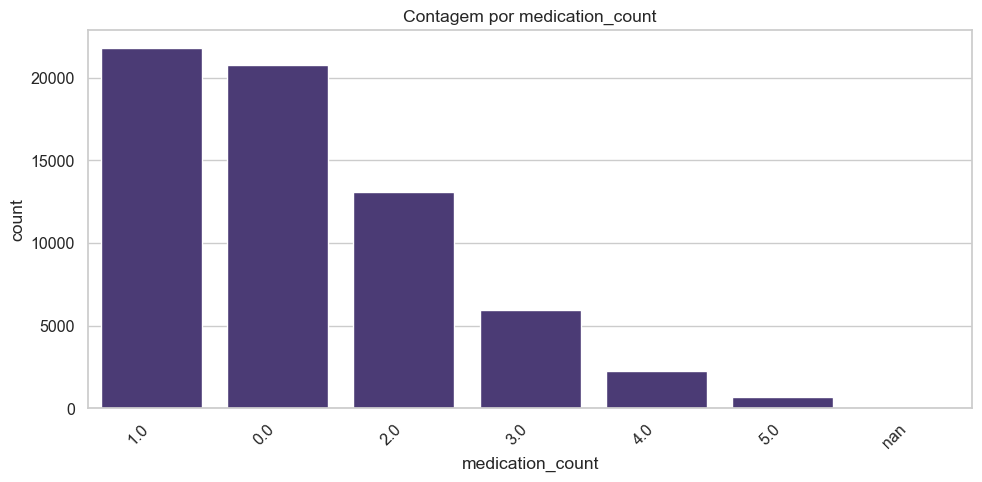

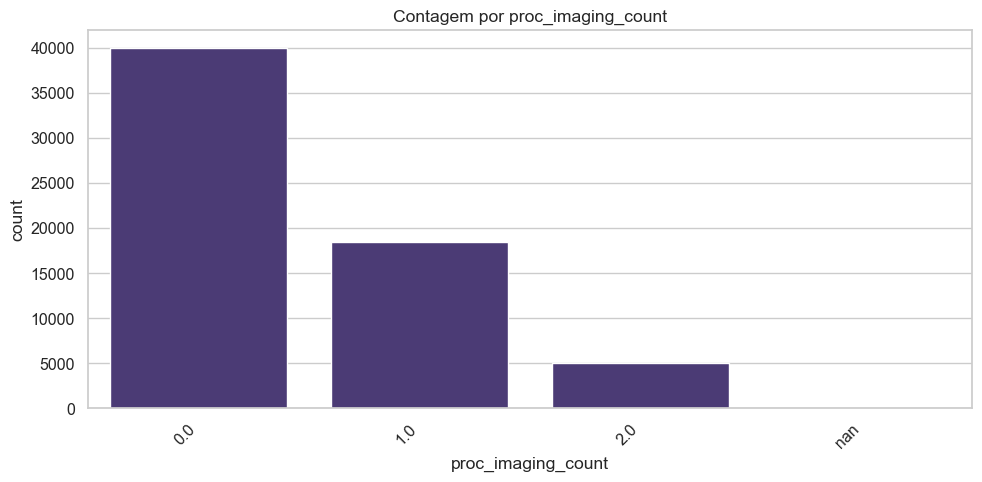

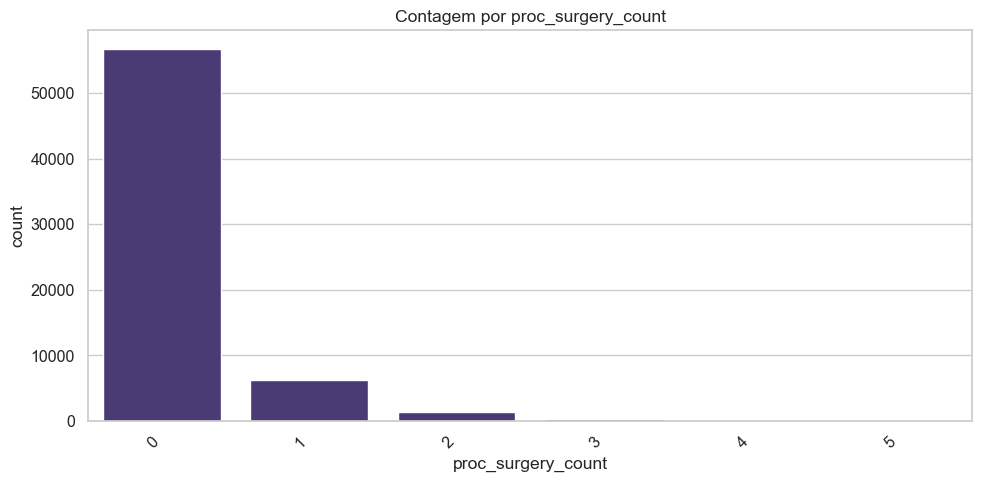

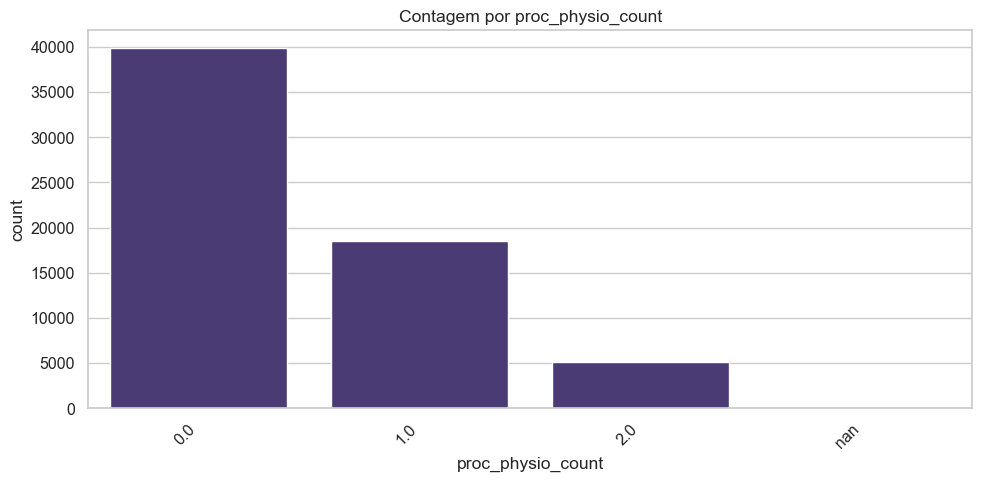

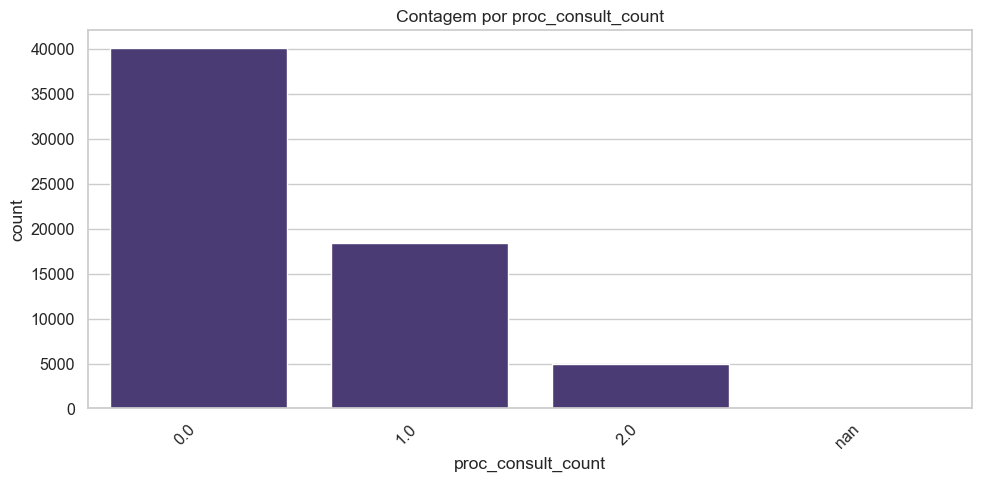

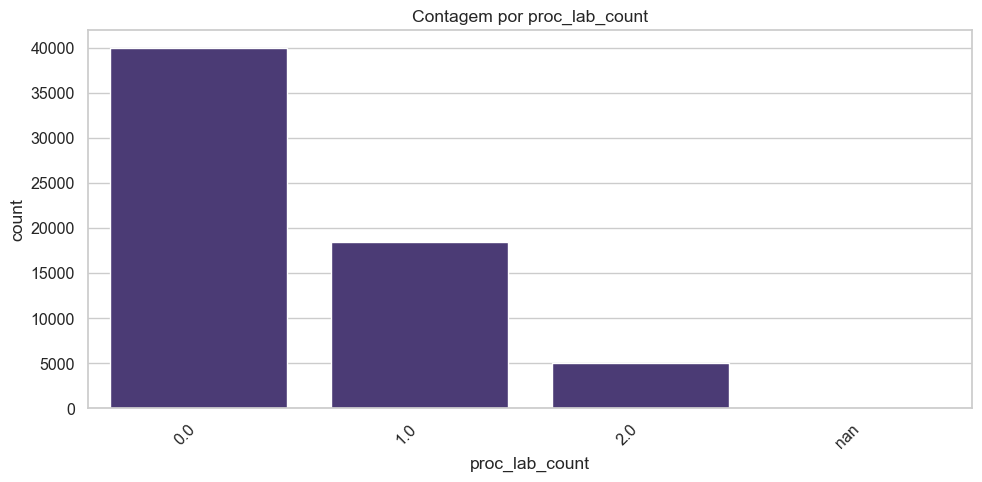

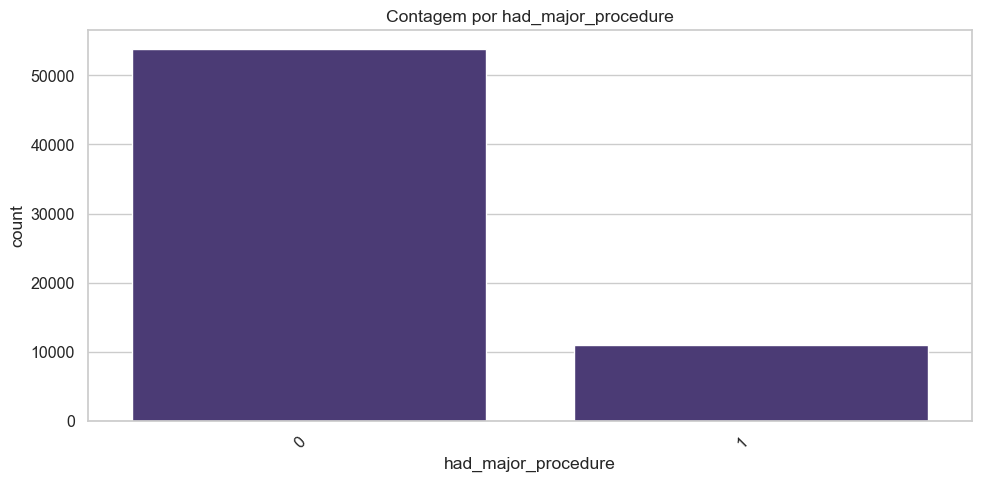

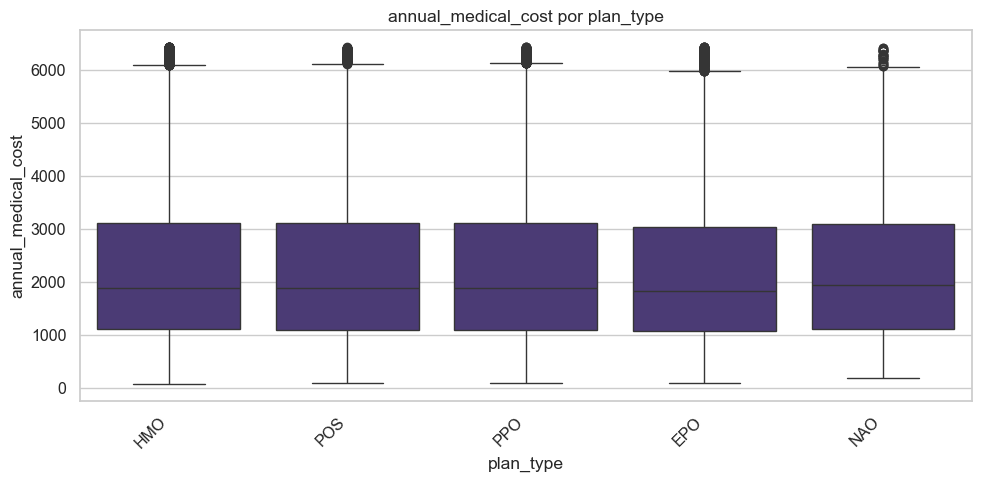

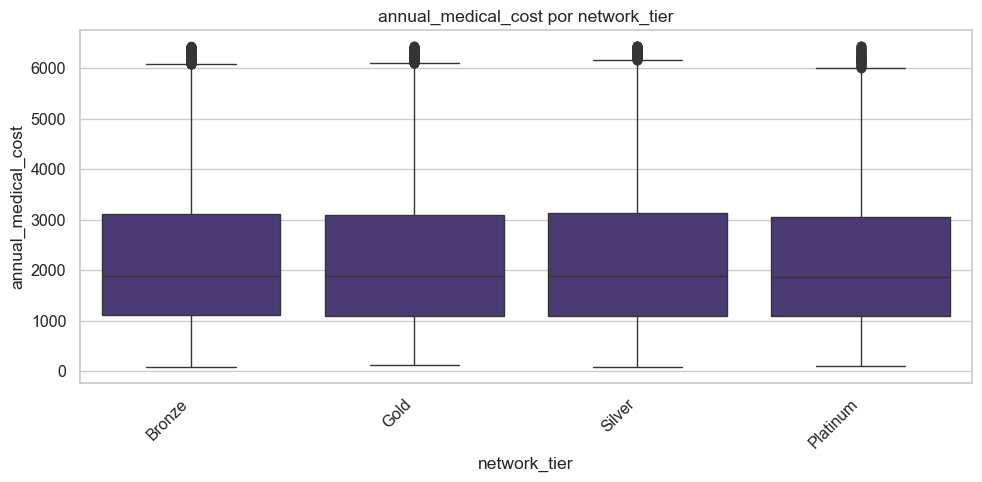

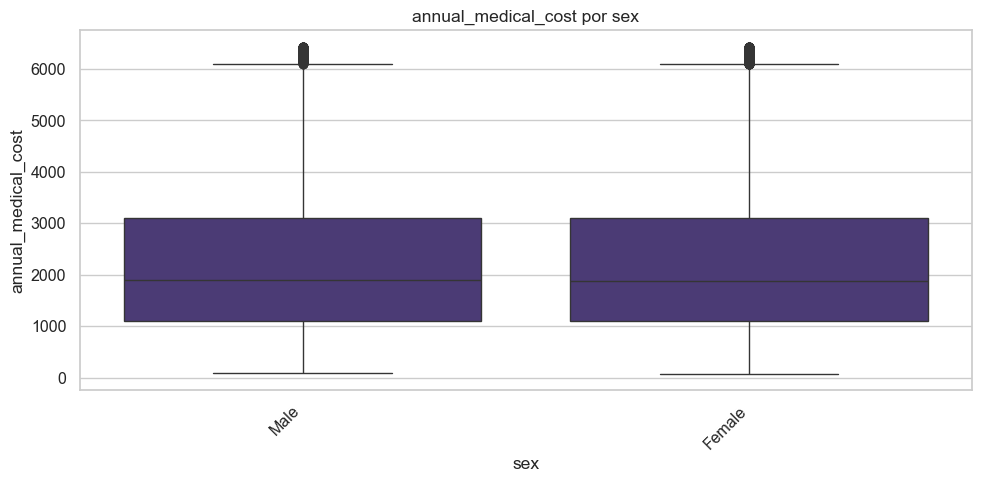

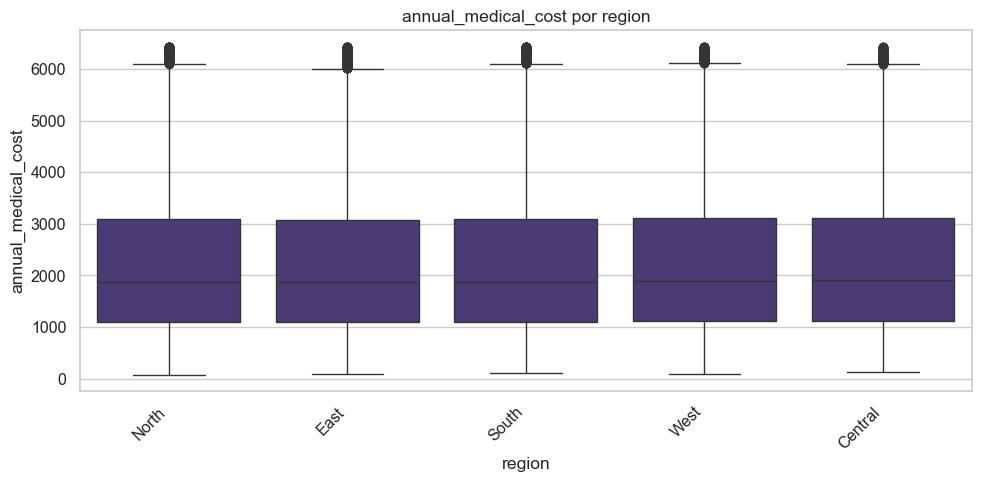

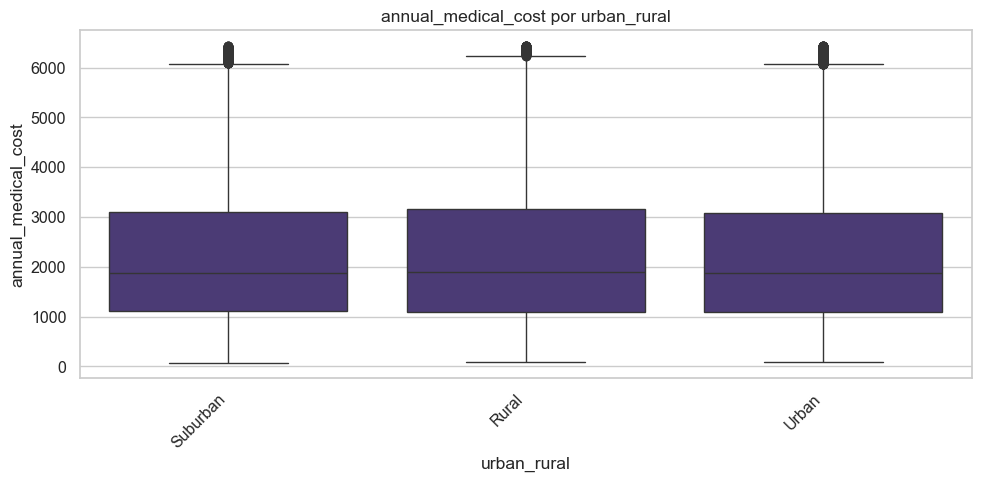

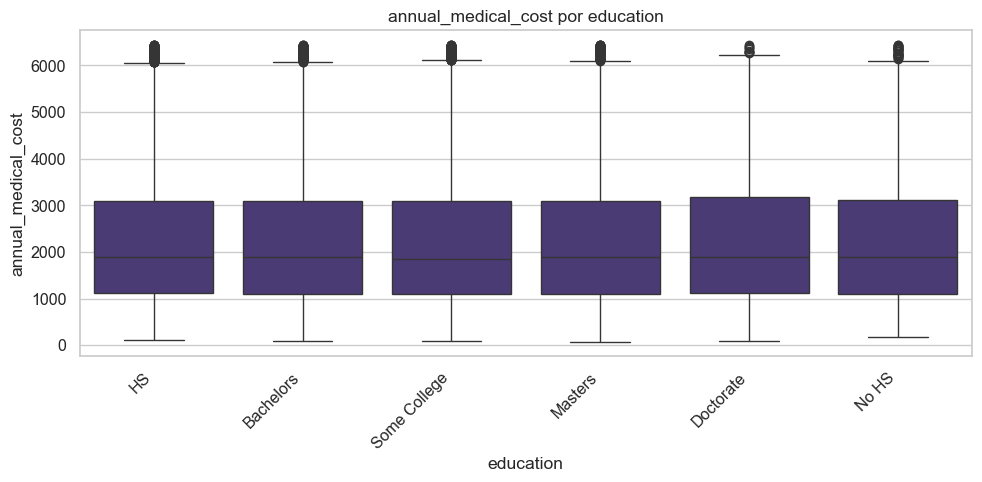

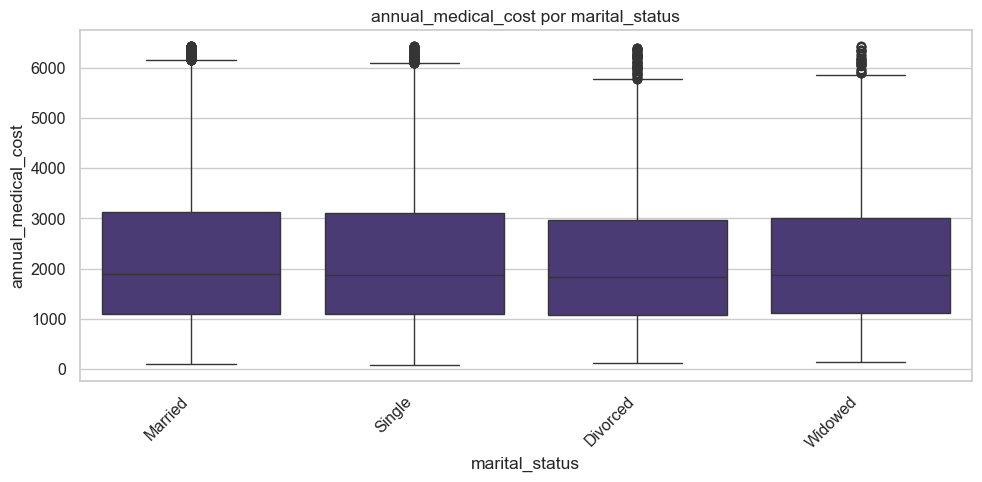

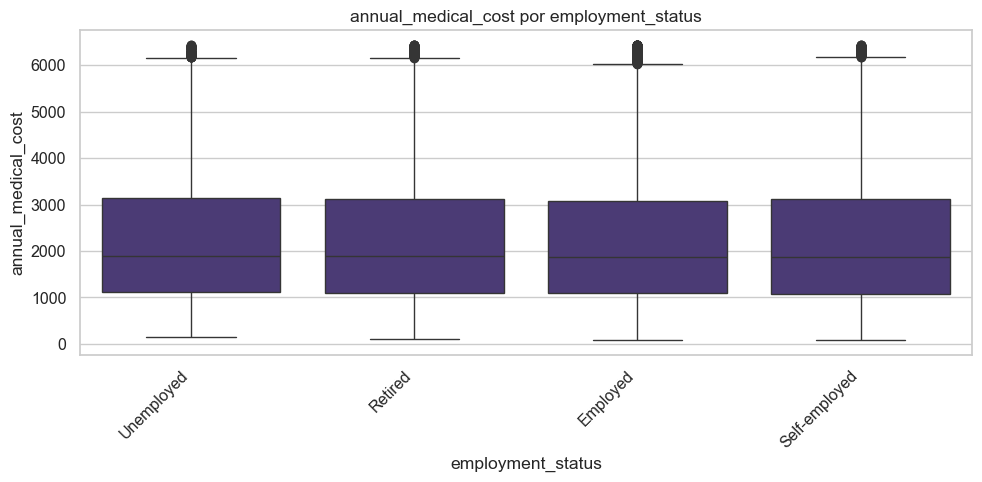

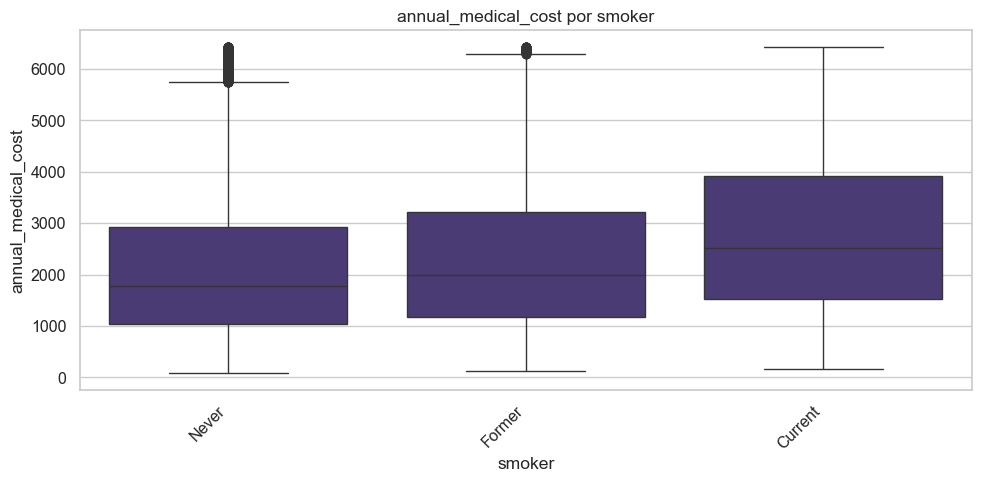

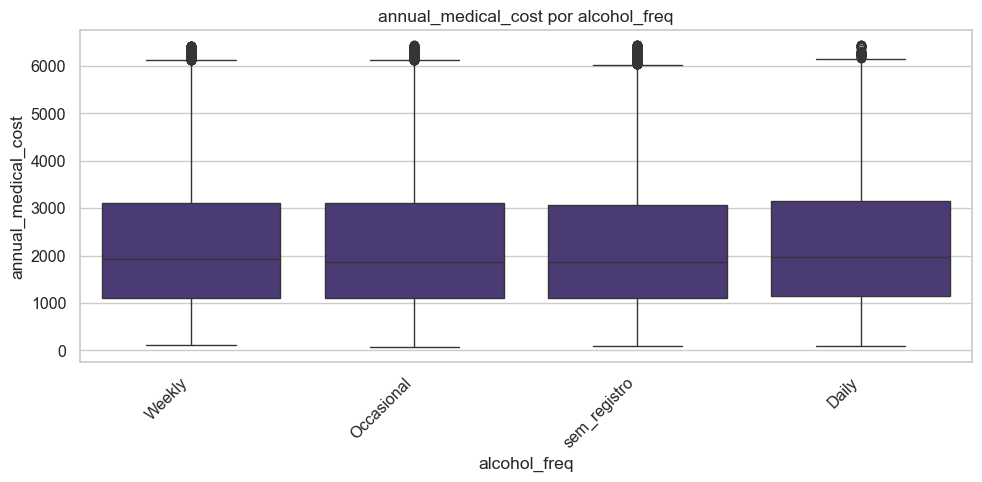

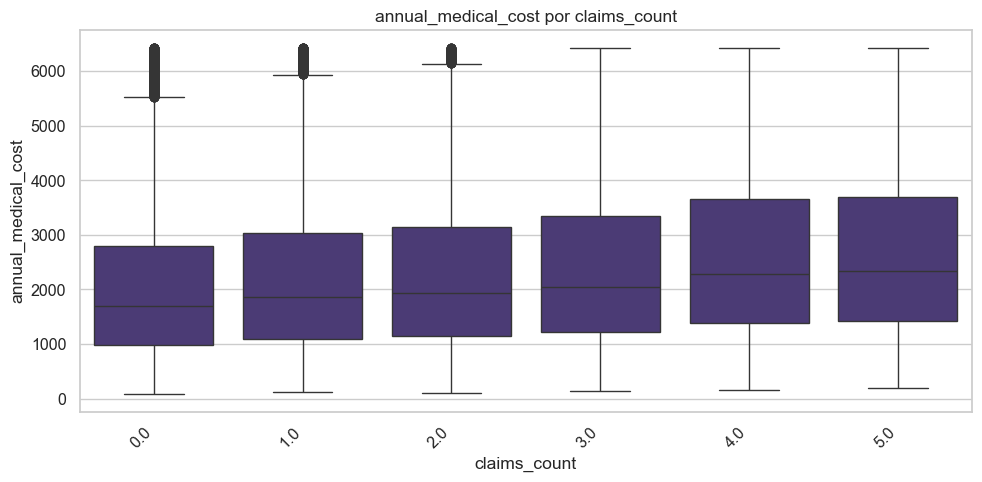

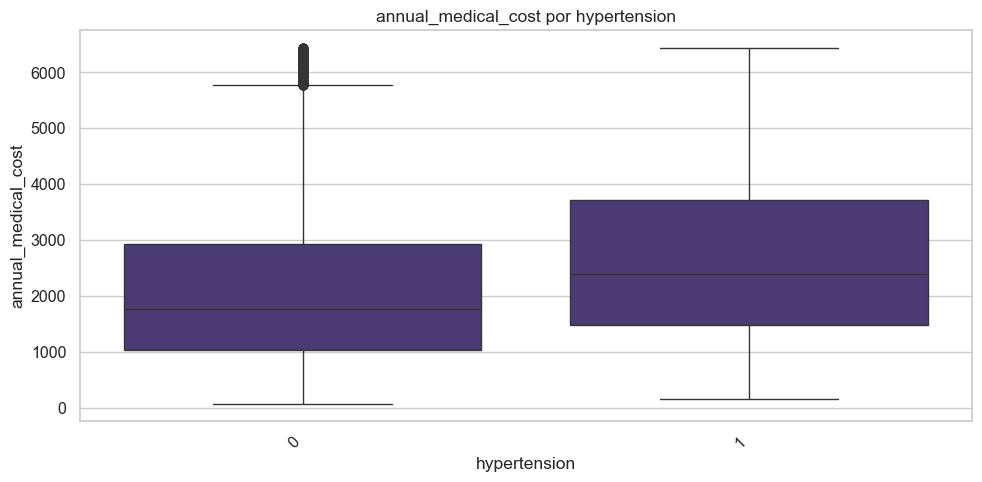

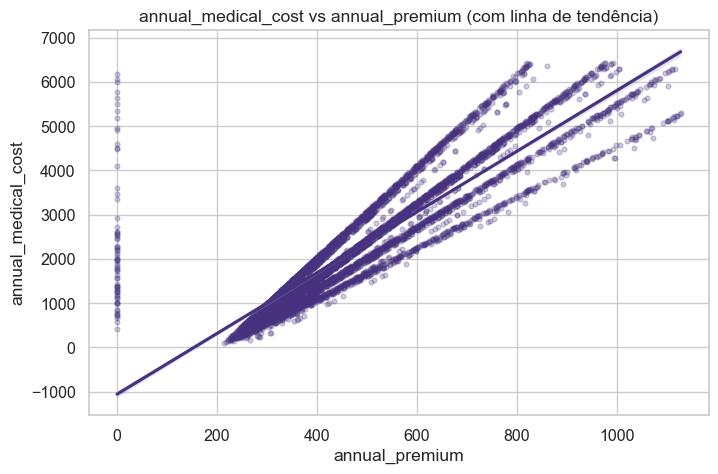

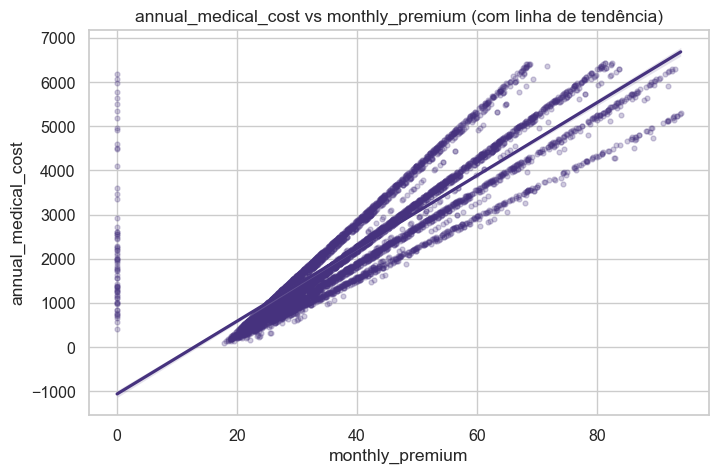

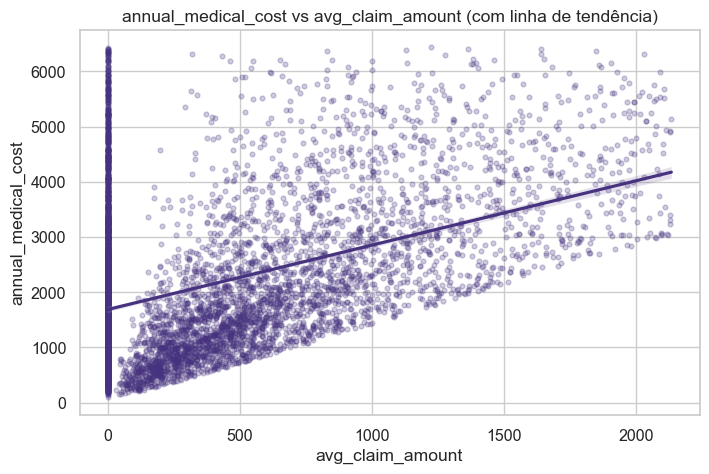

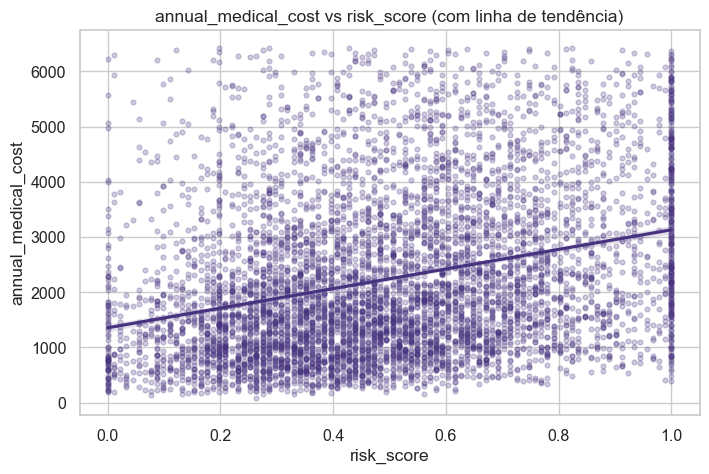

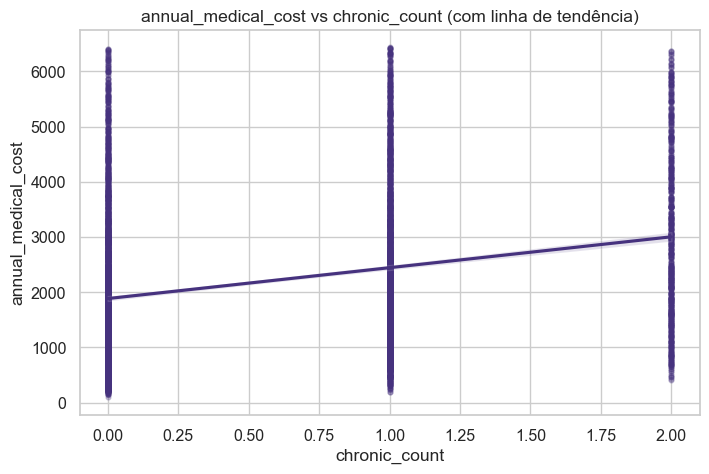

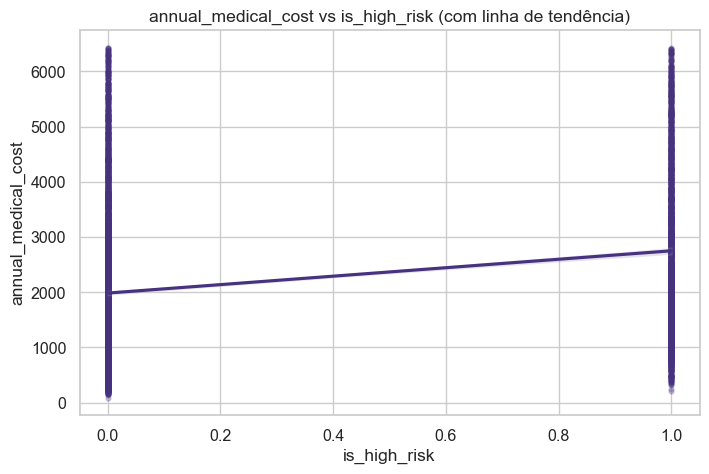

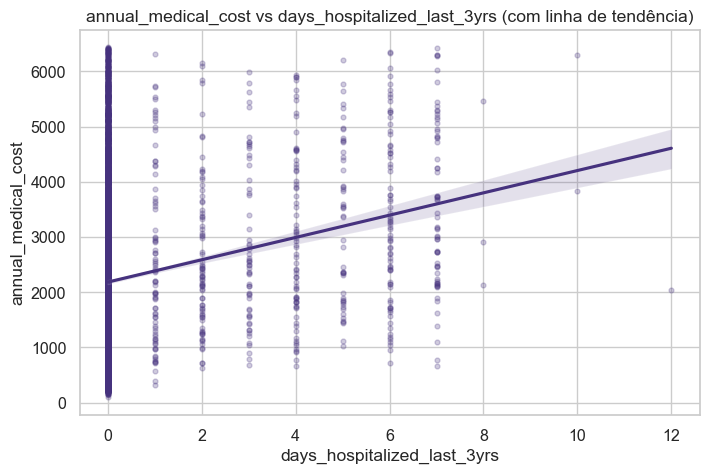

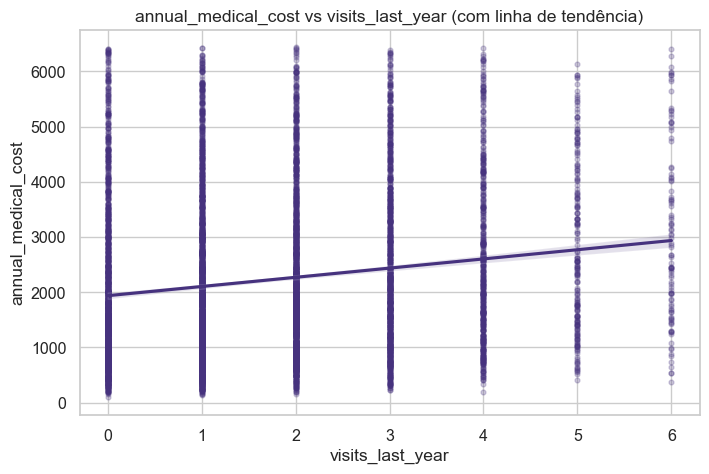

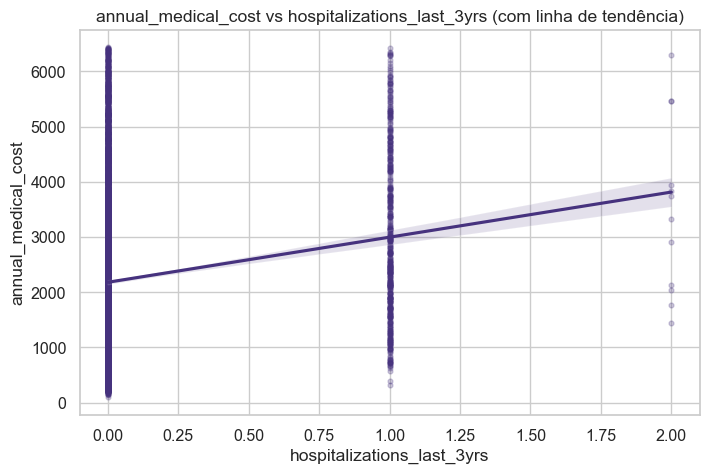

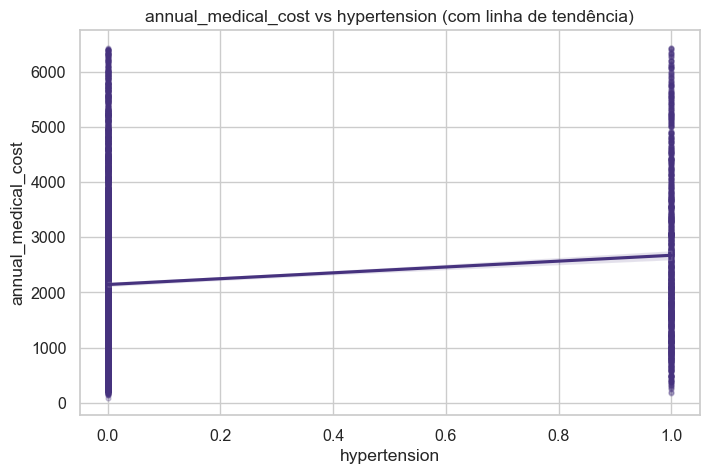

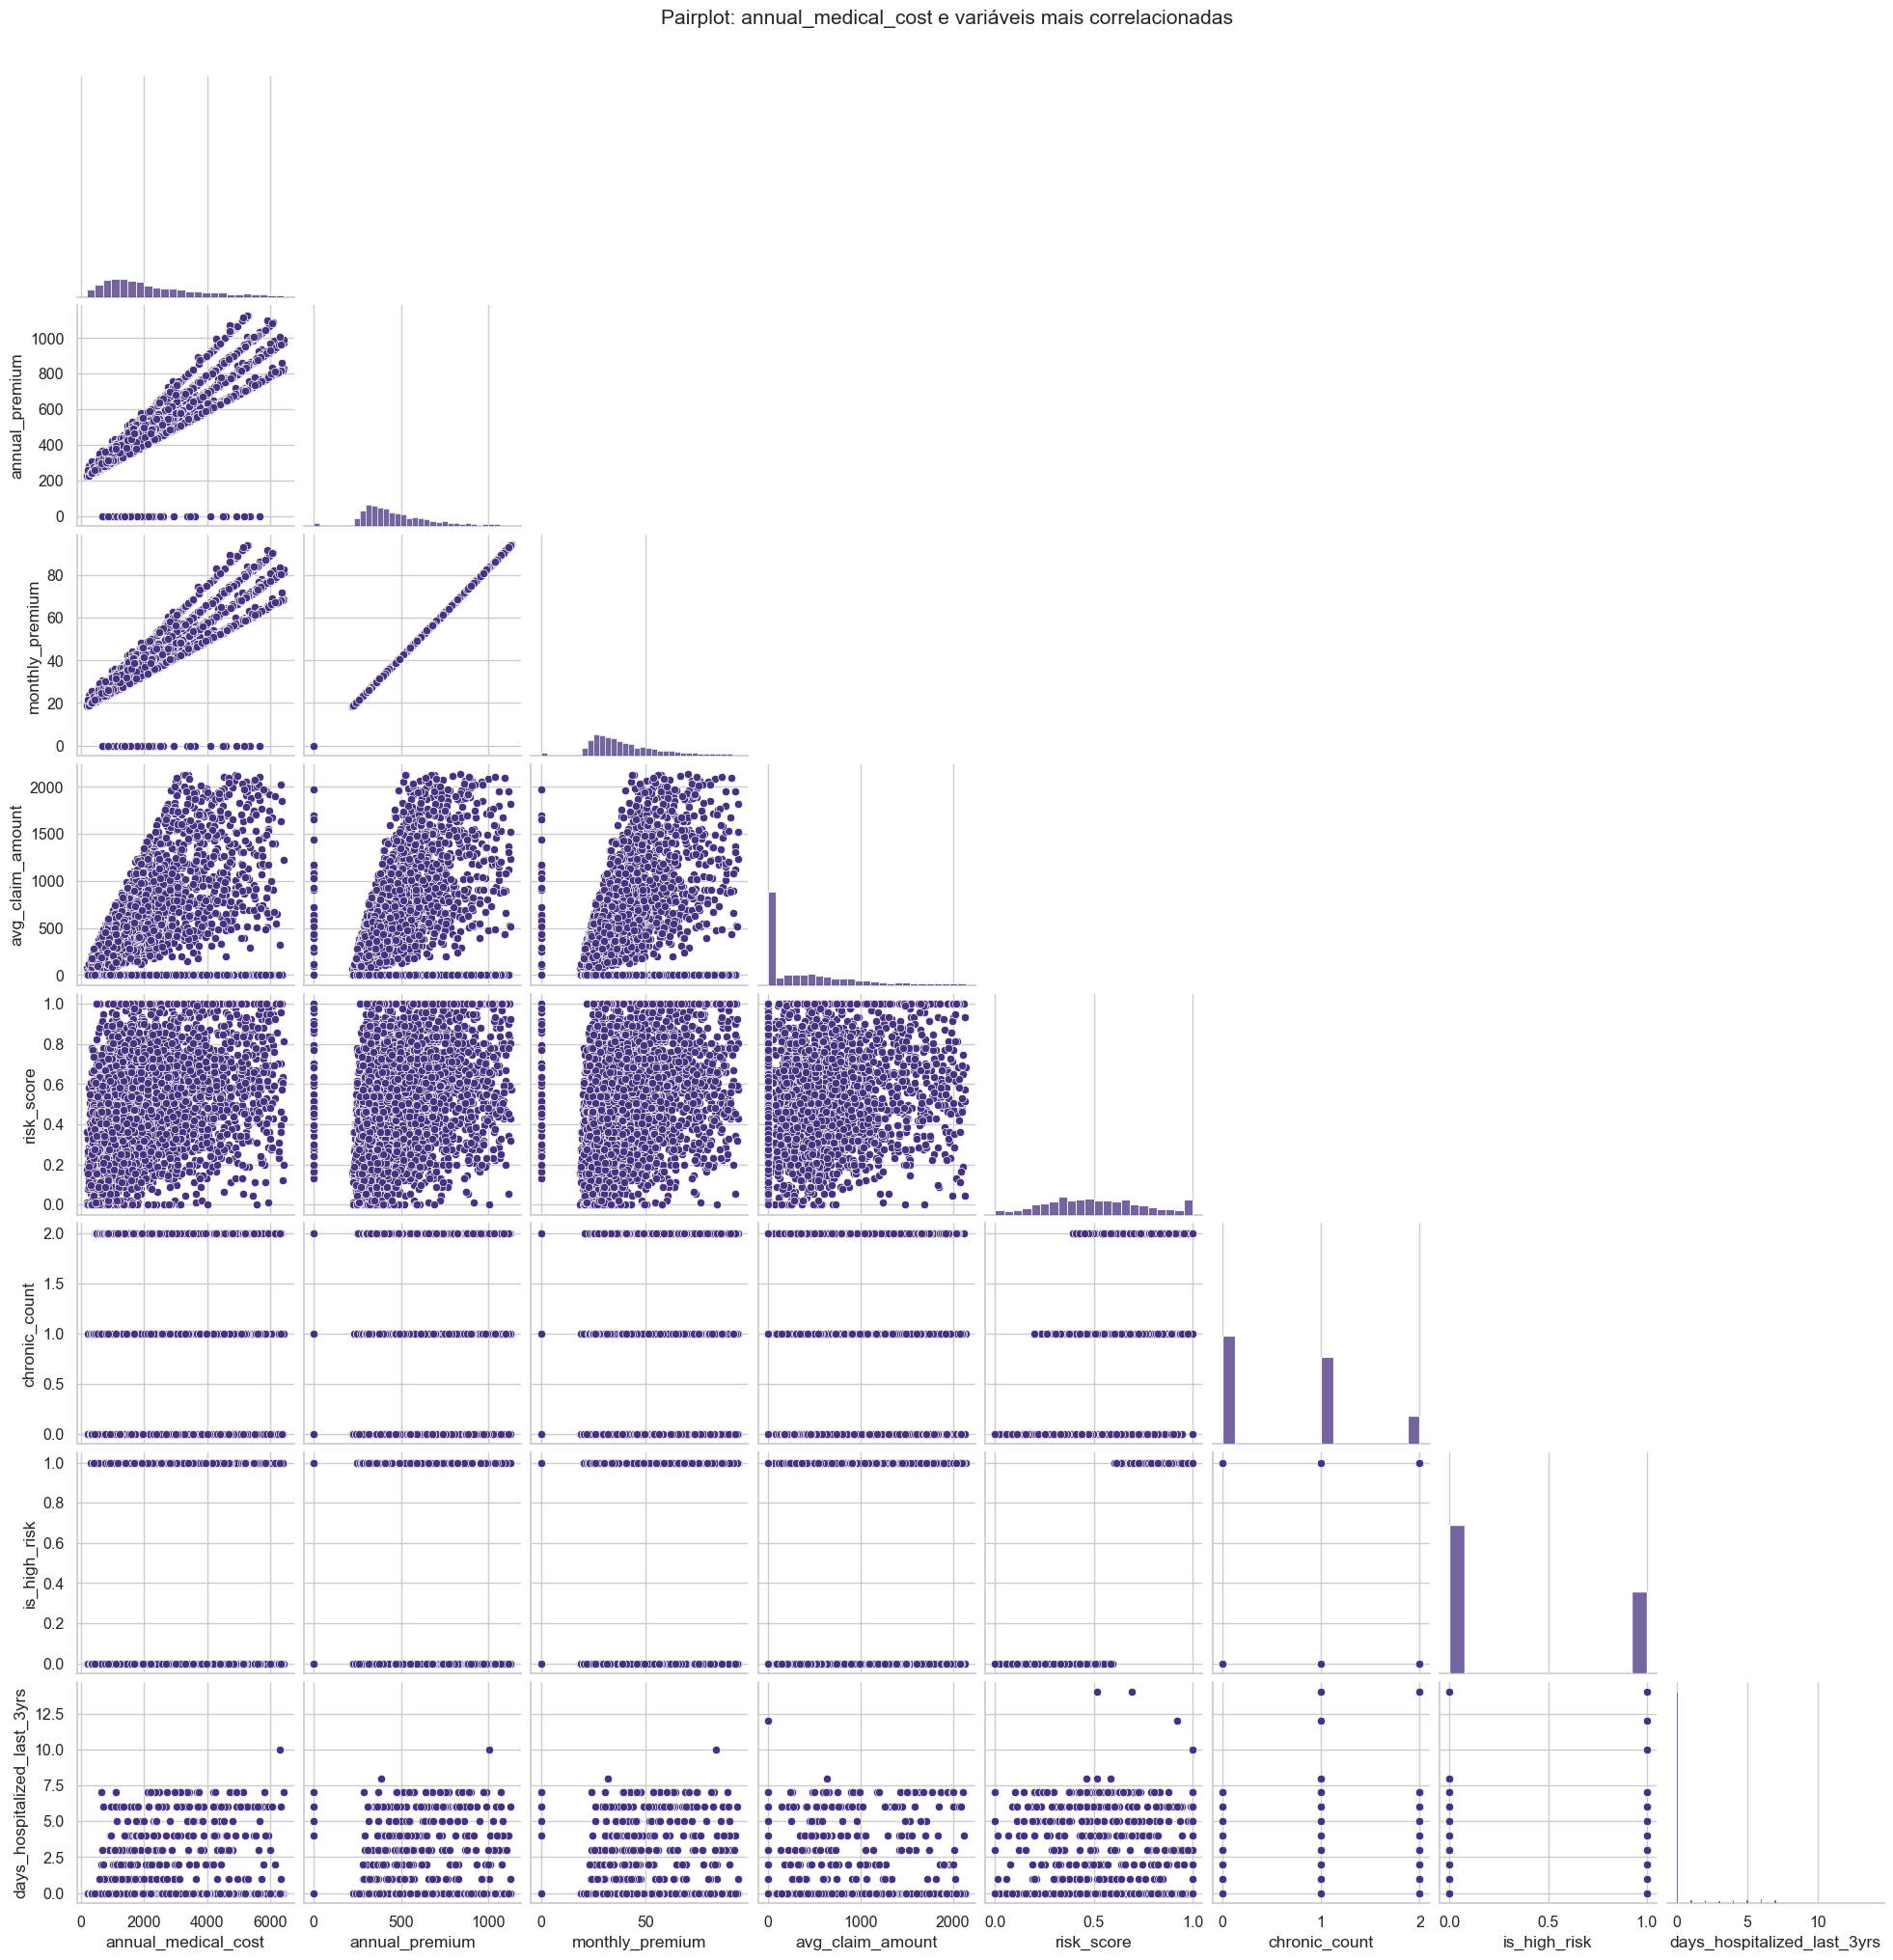

In [13]:

# === 12) Gráficos originais ===
plot_distributions(df, [c for c in num_cols if c != target])
plot_countplots(df, cat_cols, limit_each=40)
plot_boxplots_cat_target(df, cat_cols, target, max_plots=MAX_BOXPLOTS, limit_each=40)
if target:
    plot_scatter_with_target(df, [c for c in num_cols if c != target], target, max_plots=MAX_SCATTERS, sample_n=SAMPLE_FOR_SCATTER)
    plot_pairplot_top(df, target, corr_full, max_vars=MAX_PAIRPLOT_VARS)


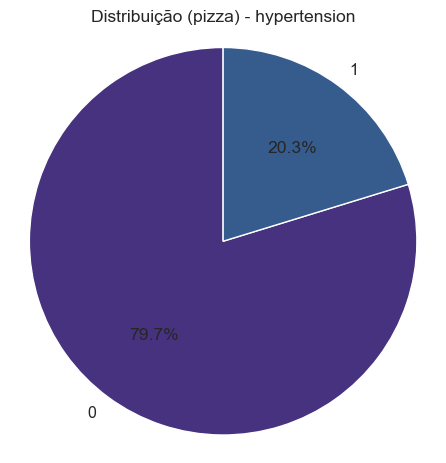

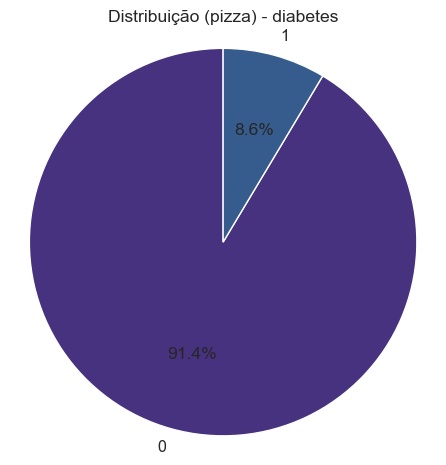

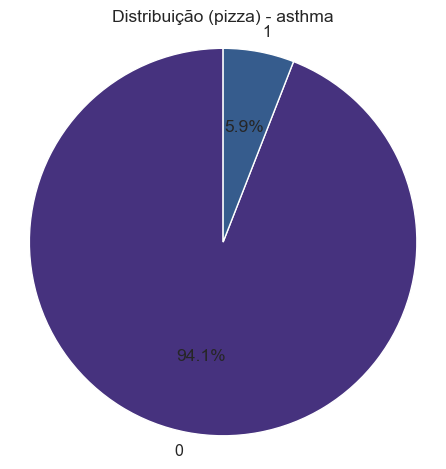

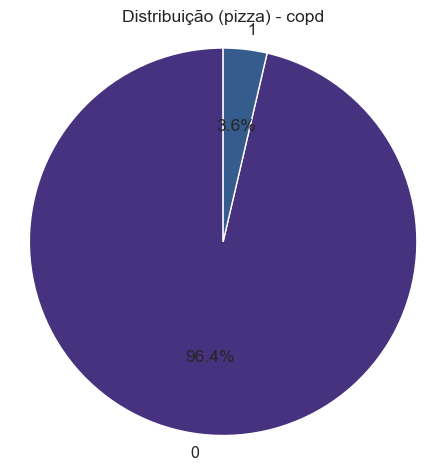

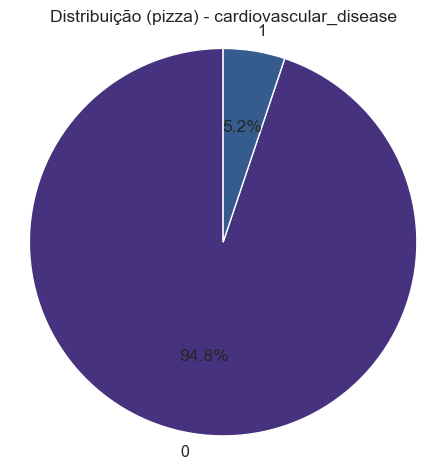

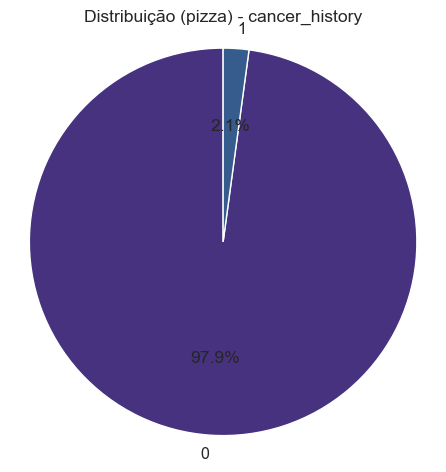

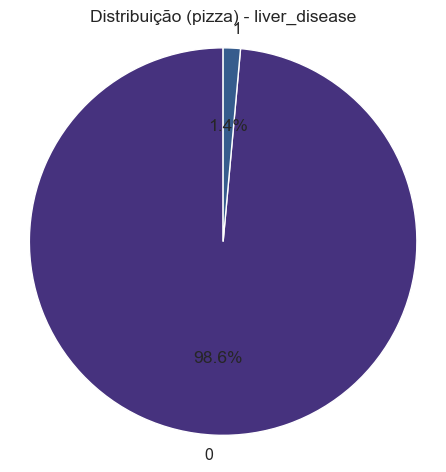

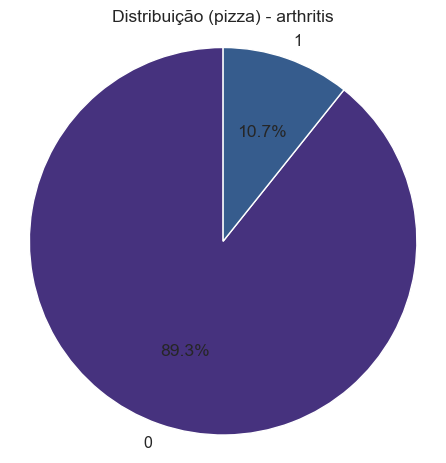

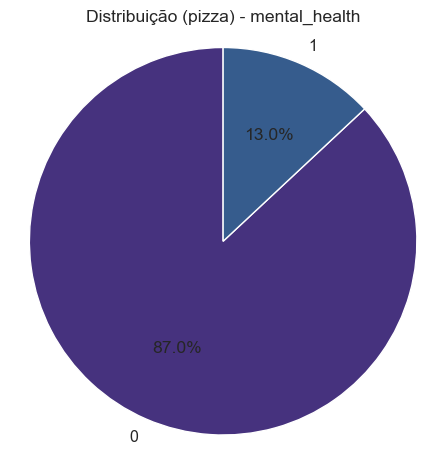

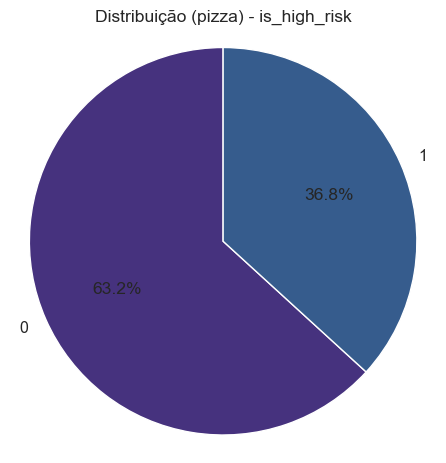

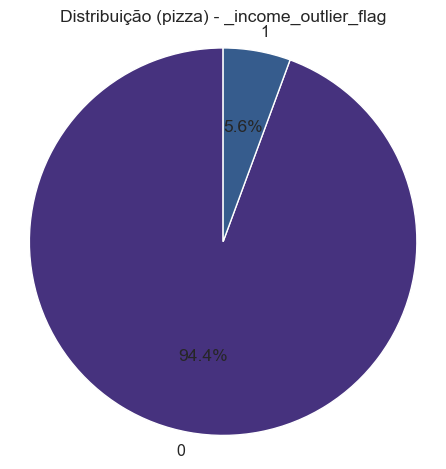

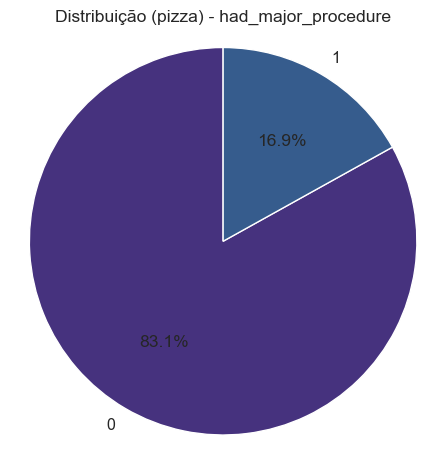

In [14]:

# === 13) Pizzas para todas as binárias ===
if bin_cols:
    plot_pies_for_binary_columns(df, bin_cols, max_pies=MAX_PIES_BINARIES)
else:
    print("[info] Nenhuma coluna binária detectada.")


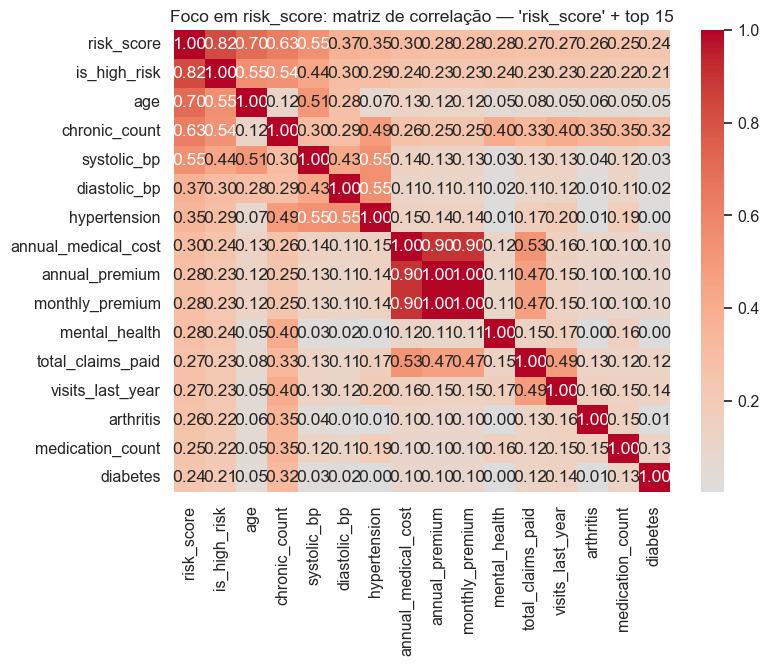

variavel  correlacao  abs_correlacao
0          is_high_risk    0.821463        0.821463
1                   age    0.700457        0.700457
2         chronic_count    0.631872        0.631872
3           systolic_bp    0.547120        0.547120
4          diastolic_bp    0.370661        0.370661
5          hypertension    0.346745        0.346745
6   annual_medical_cost    0.301832        0.301832
7        annual_premium    0.284731        0.284731
8       monthly_premium    0.284687        0.284687
9         mental_health    0.284354        0.284354
10    total_claims_paid    0.271567        0.271567
11     visits_last_year    0.267784        0.267784
12            arthritis    0.262456        0.262456
13     medication_count    0.254445        0.254445
14             diabetes    0.237133        0.237133

[ok] top_corr_with_risk_score.csv salvo.


In [15]:

# === 14) Matriz + Tabela focadas em risk_score ===
tbl_risk, _ = plot_corr_matrix_anchor(df, "risk_score", topn=TOPN_RISK, title_prefix="Foco em risk_score")
if not tbl_risk.empty:
    display(tbl_risk)
    tbl_risk.to_csv("top_corr_with_risk_score.csv", index=False)
    print("[ok] top_corr_with_risk_score.csv salvo.")


variavel  correlacao  abs_correlacao
22           risk_score    0.821463        0.821463
28                  age    0.550419        0.550419
17        chronic_count    0.539283        0.539283
18          systolic_bp    0.437487        0.437487
19         diastolic_bp    0.301017        0.301017
7          hypertension    0.292600        0.292600
1   annual_medical_cost    0.244543        0.244543
16        mental_health    0.242124        0.242124
2        annual_premium    0.231601        0.231601
3       monthly_premium    0.231543        0.231543
34     visits_last_year    0.227418        0.227418
6     total_claims_paid    0.226056        0.226056
15            arthritis    0.223034        0.223034
37     medication_count    0.218053        0.218053
8              diabetes    0.205583        0.205583

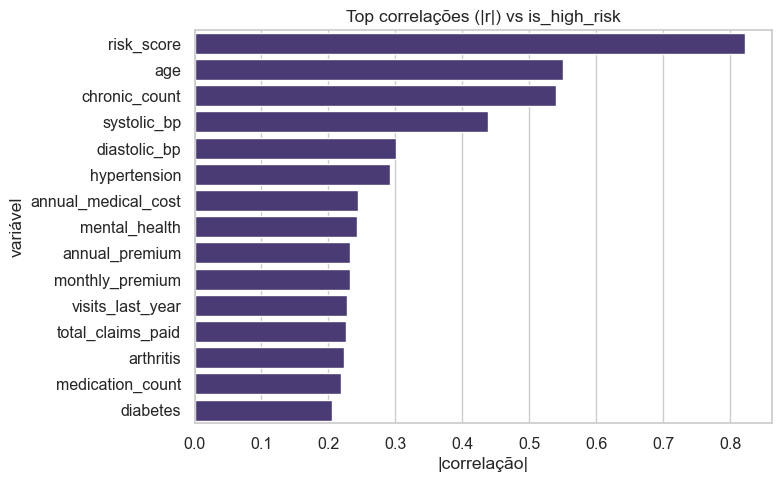

In [16]:

# === 15) Tabela vs is_high_risk (ponto-biserial) + gráfico ===
tbl_is_high = corr_with_binary_anchor(df, "is_high_risk", topn=TOPN_RISK)
if not tbl_is_high.empty:
    display(tbl_is_high)
    tbl_is_high.to_csv("top_corr_with_is_high_risk.csv", index=False)
    plt.figure(figsize=(8,5))
    sns.barplot(data=tbl_is_high, x="abs_correlacao", y="variavel")
    plt.title(tight_title("Top correlações (|r|) vs is_high_risk"))
    plt.xlabel("|correlação|"); plt.ylabel("variável")
    savefig_maybe("top_corr_is_high_risk")
    plt.tight_layout(); plt.show()


[ok] salvo: /Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/notebooks/table_by_risk_bin.csv
[ok] salvo: /Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/notebooks/table_plan_x_risk.csv
[ok] salvo: /Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/notebooks/table_plan_tier_x_risk.csv
[ok] salvo: /Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/notebooks/table_region_x_risk.csv
[ok] salvo: /Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/notebooks/table_sex_x_risk.csv

Tabela 'by_risk_bin':


/var/folders/99/0hmnt5l13rn3b4mhfw326ws00000gn/T/ipykernel_14645/3203970203.py:112: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out["by_risk_bin"] = (df2.groupby("risk_bin", dropna=True)[cost_col]
/var/folders/99/0hmnt5l13rn3b4mhfw326ws00000gn/T/ipykernel_14645/3203970203.py:116: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  out["plan_x_risk"] = (df2.pivot_table(index=c_plan, columns="risk_bin",
/var/folders/99/0hmnt5l13rn3b4mhfw326ws00000gn/T/ipykernel_14645/3203970203.py:119: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to sile

risk_bin  count         mean    median          std
0       D1   6023  1580.459299  1236.990  1181.596396
1       D2   6062  1816.875356  1454.745  1287.771643
2       D3   4996  1927.205012  1568.780  1326.327175
3       D4   6203  2068.649191  1720.250  1369.773915
4       D5   5197  2208.969750  1850.720  1407.989400
5       D6   4885  2323.538080  1951.320  1448.612259
6       D7   5808  2466.797288  2147.410  1438.802922
7       D8   4616  2638.005035  2340.745  1493.942643
8       D9   4819  2797.806603  2510.560  1506.354135
9      D10   4400  3080.898502  2873.265  1540.990016


Tabela 'plan_x_risk':


risk_bin plan_type           D1           D2           D3           D4  \
0              EPO  1566.271710  1761.128352  1906.817415  2007.379203   
1              HMO  1573.962768  1833.646632  1932.384837  2040.370504   
2              NAO  1675.638239  1967.177681  1923.000063  2239.691165   
3              POS  1517.556492  1842.516625  1924.866231  2123.278295   
4              PPO  1609.322902  1798.599591  1931.990829  2083.634237   

risk_bin           D5           D6           D7           D8           D9  \
0         2143.158699  2281.926494  2420.461467  2583.064708  2802.459700   
1         2230.848464  2325.709045  2489.966995  2664.816733  2768.987429   
2         2238.005284  2305.656159  2311.155307  2561.421679  2834.972532   
3         2183.785183  2384.718233  2490.721925  2589.121116  2817.778227   
4         2221.870128  2315.391151  2467.396373  2660.457511  2813.507412   

risk_bin          D10  
0         3050.975115  
1         3109.971675  
2         3017.589858  
3         3038.942440  
4         3089.055229


Tabela 'plan_tier_x_risk':


risk_bin plan_type network_tier           D1           D2           D3  \
0              EPO       Bronze  1610.625993  1740.523750  1857.806700   
1              EPO         Gold  1561.426723  1787.843778  1970.394277   
2              EPO     Platinum  1534.738333  1718.455354  1640.179524   
3              EPO       Silver  1542.696400  1774.680623  2004.060926   
4              HMO       Bronze  1529.977997  1860.112347  1925.659846   
5              HMO         Gold  1585.157226  1793.027681  1799.559137   
6              HMO     Platinum  1557.044462  1872.599590  1953.525608   
7              HMO       Silver  1620.775985  1836.689909  1980.772839   
8              NAO       Bronze  1672.104545  2178.051957  2034.754400   
9              NAO         Gold  1365.348077  1966.307143  2013.635714   
10             NAO     Platinum  1833.672308  1740.389459  1910.900870   
11             NAO       Silver  1782.222553  1956.239744  1892.797674   
12             POS       Bronze  1494.832415  1842.571812  1934.815377   
13             POS         Gold  1658.307153  1796.472788  1794.994336   
14             POS     Platinum  1464.017778  1626.528406  2084.644074   

risk_bin           D4           D5           D6           D7           D8  \
0         2086.892447  2156.248140  2361.939777  2389.291960  2599.088102   
1         1956.981525  2143.710629  2349.241203  2502.331988  2639.744412   
2         1806.148105  2003.640563  2213.818028  2410.680811  2661.060845   
3         2006.087262  2161.625747  2198.543750  2391.197469  2515.491588   
4         2052.749591  2291.918318  2345.971480  2510.367013  2638.369633   
5         2050.963325  2201.869211  2331.734698  2403.973026  2702.953477   
6         2103.886359  2088.662609  2175.286647  2593.608667  2660.858047   
7         1999.703856  2232.204323  2351.508977  2502.528538  2678.962838   
8         2392.529259  2300.725625  2754.949231  2383.301111  2322.551250   
9         2128.572466  2285.161200  2203.560833  2302.745000  2413.854651   
10        2279.413448  1963.558571  2157.505500  2179.548846  3210.438462   
11        2425.998367  2291.352609  2419.688222  2331.539167  2464.756585   
12        2104.056868  2090.932302  2461.332765  2560.803233  2448.457674   
13        2039.713293  2293.445620  2326.769211  2326.817429  2871.250769   
14        2216.442500  2138.750909  2072.950161  2689.067123  2458.331311   

risk_bin           D9          D10  
0         2824.799655  3212.967889  
1         2738.263576  3133.716947  
2         2646.211818  2986.939041  
3         2868.119215  2931.731653  
4         2897.888004  3175.745238  
5         2706.298927  3083.432269  
6         2716.999048  3085.868322  
7         2711.846234  3109.495730  
8         2744.044000  2412.630000  
9         3052.265238  3045.406667  
10        2915.644667  2899.645000  
11        2637.543023  3354.785263  
12        2705.202083  2948.511168  
13        2921.086033  3240.590198  
14        2781.685882  2647.860625


Tabela 'region_x_risk':


risk_bin   region           D1           D2           D3           D4  \
0         Central  1670.230256  1800.277577  1883.567451  2138.002853   
1            East  1575.537222  1816.961308  1898.045250  2062.122473   
2           North  1570.264970  1789.723526  1910.063077  2057.058403   
3           South  1573.337384  1862.414679  1961.362615  2064.108062   
4            West  1543.149363  1787.069404  1961.197816  2053.886897   

risk_bin           D5           D6           D7           D8           D9  \
0         2281.324019  2233.699340  2492.559899  2668.283625  2798.108630   
1         2208.863615  2375.912767  2443.303795  2584.675348  2770.764436   
2         2223.630453  2314.242909  2421.822248  2689.892844  2794.826772   
3         2164.645258  2286.692440  2476.067838  2622.186295  2798.701771   
4         2214.377320  2391.735750  2515.757527  2640.582695  2830.602427   

risk_bin          D10  
0         3056.473487  
1         3064.265656  
2         3127.310901  
3         3104.668143  
4         3025.218606


Tabela 'sex_x_risk':


risk_bin     sex           D1           D2           D3           D4  \
0         Female  1588.785738  1806.307895  1933.097393  2050.341989   
1           Male  1577.686144  1827.849901  1926.352569  2091.344126   

risk_bin           D5           D6           D7           D8           D9  \
0         2209.964197  2286.777119  2467.697435  2666.422333  2769.141870   
1         2197.198617  2371.952735  2486.287490  2609.271704  2810.682789   

risk_bin          D10  
0         3059.173609  
1         3090.331286

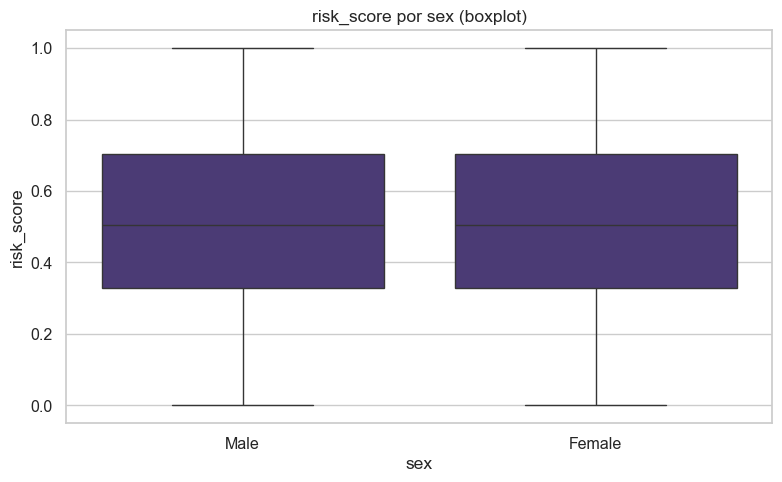

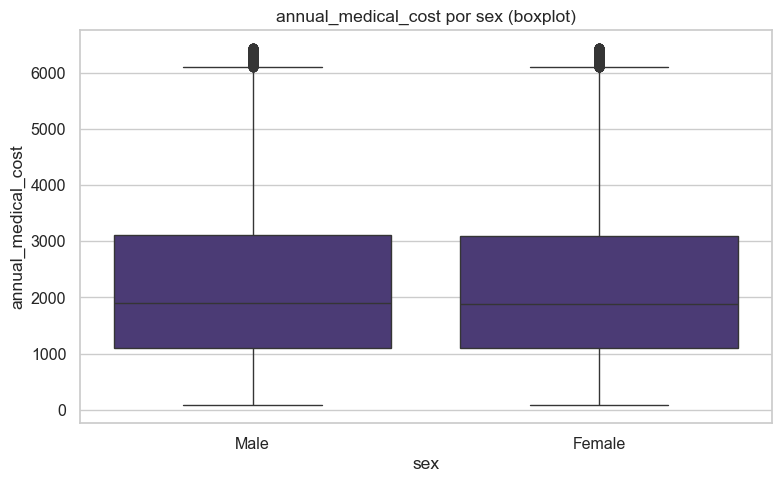

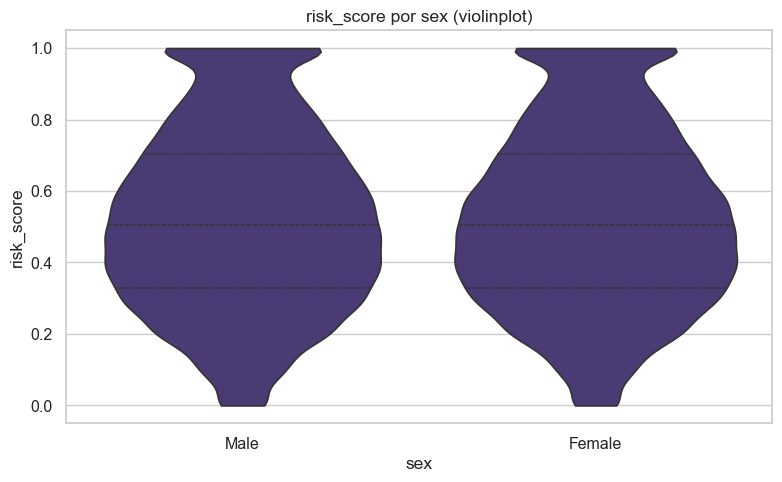

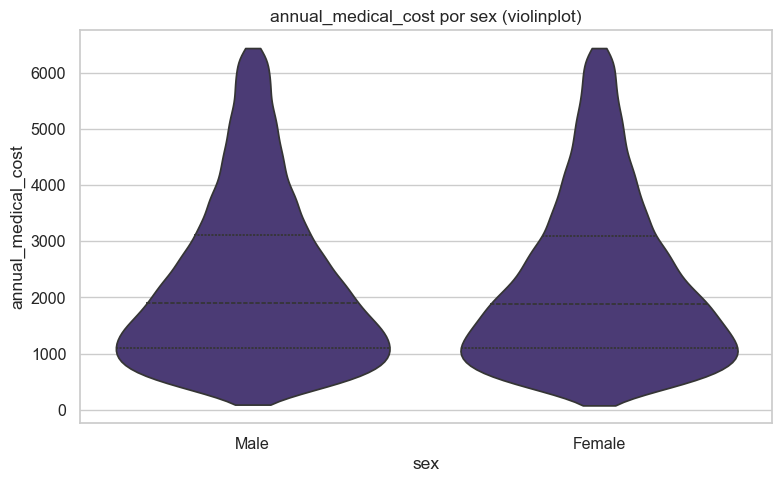

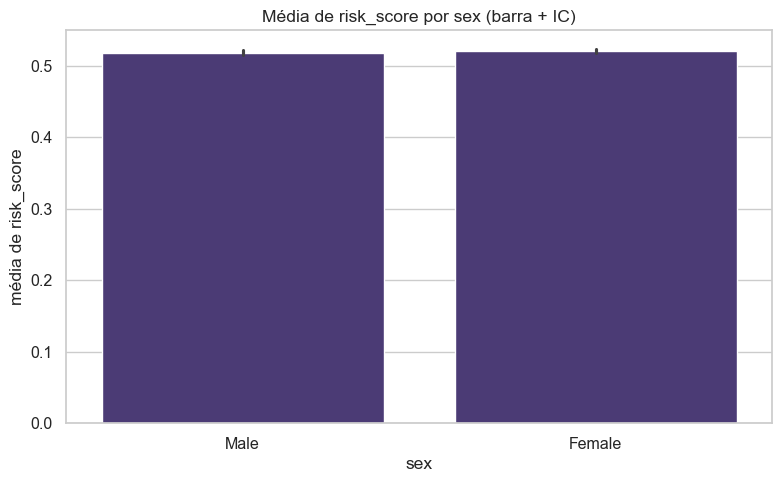

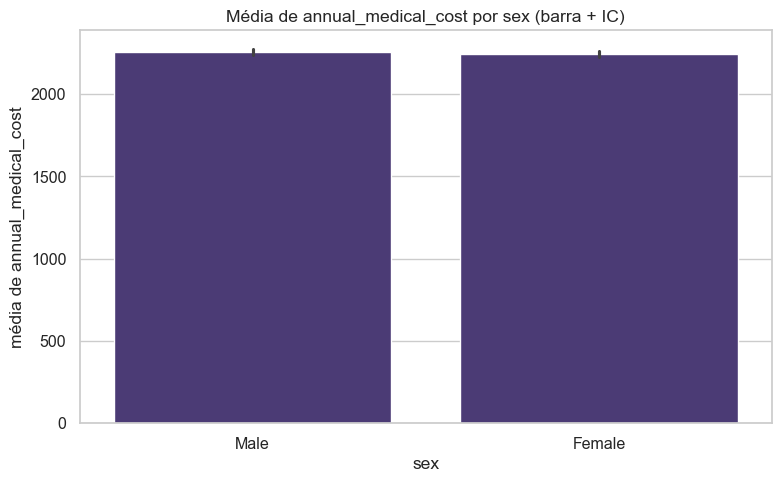

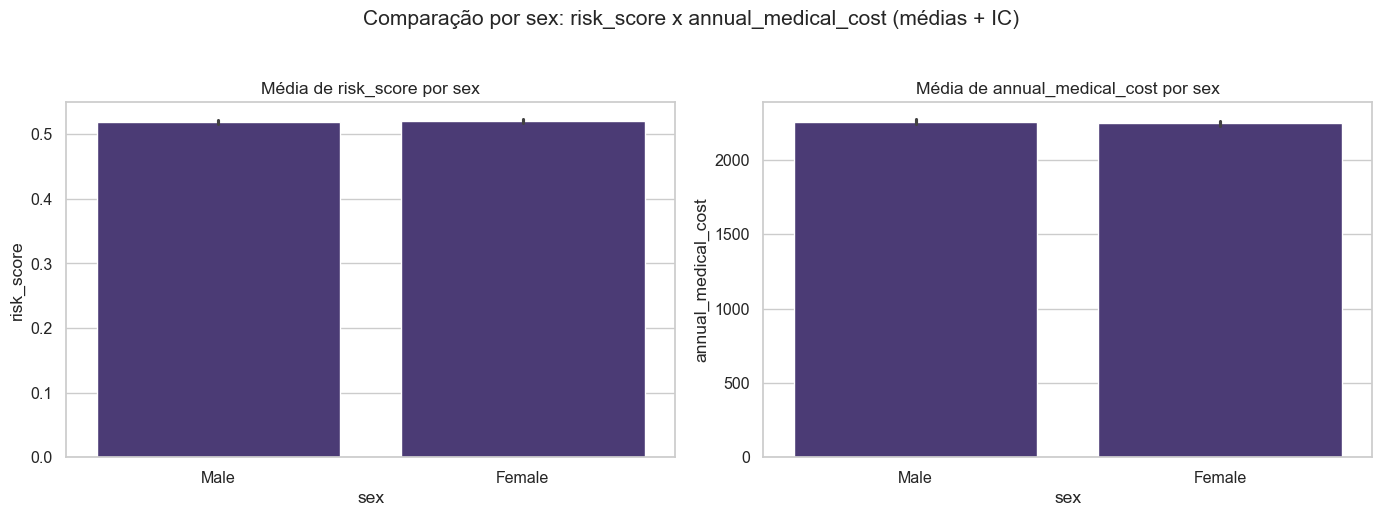

In [17]:

# === 16) Tabelas multivariáveis (annual_medical_cost × risk_score × categorias) ===
mv = multivar_tables(df, cost_col="annual_medical_cost", risk_col="risk_score")
for k, v in mv.items():
    print(f"\nTabela '{k}':")
    display(v.head(15))
  # === 17) Comparações por sexo (Male, Female, no_data) ===
plot_sex_risk_cost_comparisons(
    df,
    sex_col="sex",
    risk_col="risk_score",
    cost_col="annual_medical_cost"
)


## 17) Encerramento
CSVs gerados (quando aplicáveis):

- `top_corr_with_risk_score.csv`
- `top_corr_with_is_high_risk.csv`
- `table_by_risk_bin.csv`, `table_plan_x_risk.csv`, `table_plan_tier_x_risk.csv`, `table_region_x_risk.csv`, `table_sex_x_risk.csv`

Ajuste `CSV_PATH`, `SAVE_FIGS` e limites (`MAX_*`) conforme a necessidade.
